ver 8 (6), v10

In [2]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from typing import Tuple

import cv2
import json
from tqdm.notebook import tqdm


import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from collections import Counter
import shutil 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Tuple, Optional

In [3]:
base_input_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD" 
image_dir = os.path.join(base_input_dir, "images")
annotation_dir = os.path.join(base_input_dir, "Annotations")
excel_path = "/kaggle/input/btxrd-data/classification.xlsx"

In [4]:
# Đọc file Excel
# file_path = '/kaggle/input/btxrd-data/classification.xlsx'
df = pd.read_excel(excel_path)

# Hiển thị 10 dòng đầu tiên
df.head(10)

,image_id,center,age,gender,neoplasm,tumor_type,img_type,skeletal_type,bones_type,points,area,image_area,tumor_ratio,image_filename,type
0,IMG000001,1,48,F,malignant,other mt,frontal,pelvis,hip bone,"[[[2027.9285714285713, 1219.9285714285713], [2...",294967,7701561.0,3.83,IMG000001.jpeg,train
1,IMG000002,1,12,M,malignant,osteosarcoma,frontal,lower limb,tibia,"[[[895.6756756756756, 614.1981981981984], [895...",131041,4972480.0,2.64,IMG000002.jpeg,train
2,IMG000003,1,12,M,malignant,osteosarcoma,lateral,lower limb,tibia,"[[[811.7117117117116, 729.5135135135137], [831...",120650,6900832.0,1.75,IMG000003.jpeg,train
3,IMG000004,1,52,M,malignant,osteosarcoma,frontal,lower limb,foot,"[[[1302.6698113207547, 1734.9056603773583], [1...",91065,7214337.0,1.26,IMG000004.jpeg,train
4,IMG000005,1,52,M,malignant,osteosarcoma,oblique,lower limb,foot,"[[[1294.2446043165467, 1594.1870503597122], [1...",88469,7017152.0,1.26,IMG000005.jpeg,train
5,IMG000006,1,62,M,malignant,osteosarcoma,frontal,lower limb,femur,"[[[591.9130434782609, 1916.3043478260868], [47...",806550,5627824.0,14.33,IMG000006.jpeg,train
6,IMG000007,1,62,M,malignant,osteosarcoma,lateral,lower limb,femur,"[[[868.3636363636363, 420.45454545454544], [92...",592080,5172384.0,11.45,IMG000007.jpeg,train
7,IMG000008,1,6,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[585.0, 904.7058823529412], [577.35294117647...",61063,2650000.0,2.30,IMG000008.jpeg,train
8,IMG000009,1,6,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[671.6216216216216, 1090.9819819819818], [64...",49362,3085000.0,1.60,IMG000009.jpeg,val
9,IMG000010,1,16,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[327.1296296296297, 1343.1604938271603], [36...",130881,4866640.0,2.69,IMG000010.jpeg,train


# **Xử lý ảnh**

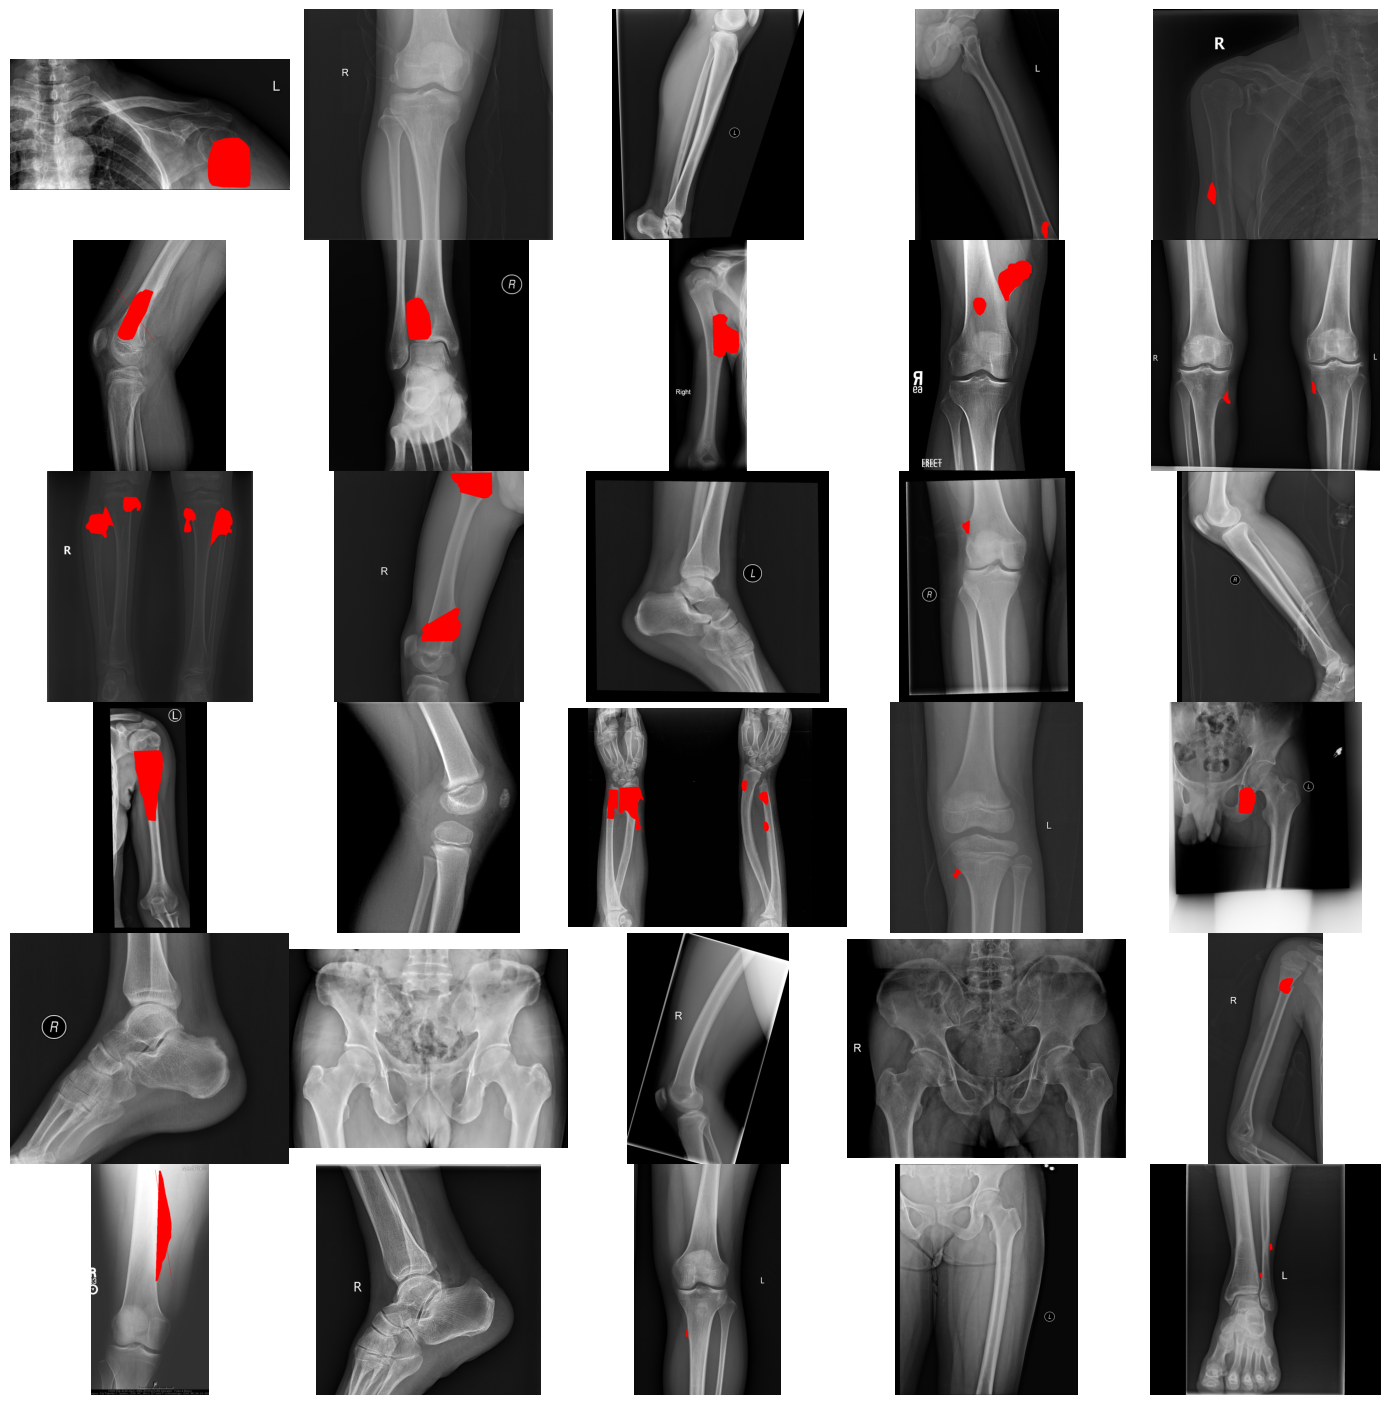

In [5]:
# in 30 ảnh trước xử lý
num_images_to_show = 30
images_per_row = 5  # Số ảnh mỗi hàng
mask_color = [255, 0, 0]  # Red

def create_mask(img_size: Tuple[int, int], ann_path: str) -> np.ndarray:
    mask = Image.new('L', img_size, 0)
    if os.path.exists(ann_path):
        try:
            with open(ann_path, 'r') as f:
                data = json.load(f)
                for shape in data.get('shapes', []):
                    points = shape.get('points', [])
                    polygon_points = [(int(x), int(y)) for x, y in points]
                    if polygon_points:
                        ImageDraw.Draw(mask).polygon(polygon_points, outline=1, fill=1)
        except Exception as e:
            print(f"Lỗi annotation {ann_path}: {e}")
    return np.array(mask)

# Lấy danh sách tất cả ảnh trong thư mục
all_filenames = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Chọn ngẫu nhiên 30 ảnh
selected_filenames = random.sample(all_filenames, min(num_images_to_show, len(all_filenames)))

# Plot ảnh với mask
plt.figure(figsize=(18, 18))  # Tăng kích thước ảnh
for i, fname in enumerate(selected_filenames):
    img_path = os.path.join(image_dir, fname)
    ann_fname = os.path.splitext(fname)[0] + '.json'
    ann_path = os.path.join(annotation_dir, ann_fname)

    try:
        img_pil = Image.open(img_path).convert('L')
        img_np = np.array(img_pil)

        mask_np = create_mask(img_pil.size, ann_path)
        color_img = np.stack([img_np] * 3, axis=-1)
        color_img[mask_np == 1] = mask_color

        # Chia bố cục thành 6 hàng và 5 cột (số ảnh mỗi hàng là 5)
        plt.subplot(6, 5, i + 1)
        plt.imshow(color_img)
        plt.axis('off')  # Tắt trục
    except Exception as e:
        print(f"Lỗi khi xử lý {fname}: {e}")
        continue

# Loại bỏ khoảng trống giữa các ảnh
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


Tìm thấy 3746 ảnh để xử lý.
Bắt đầu xử lý ảnh và lưu vào: /kaggle/working/btxrd-v2.2


Processing Images:   0%|          | 0/3746 [00:00<?, ?it/s]

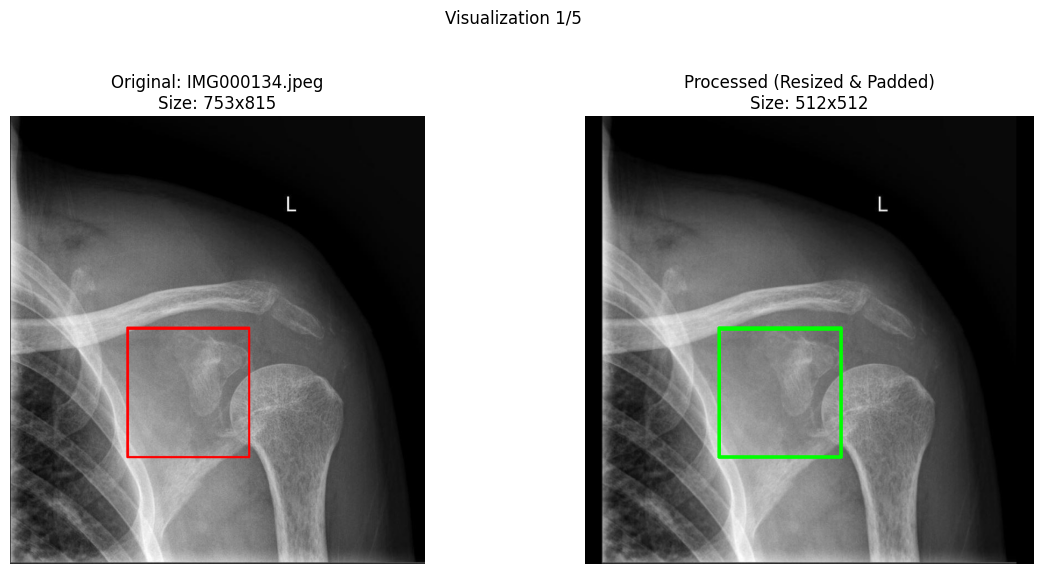

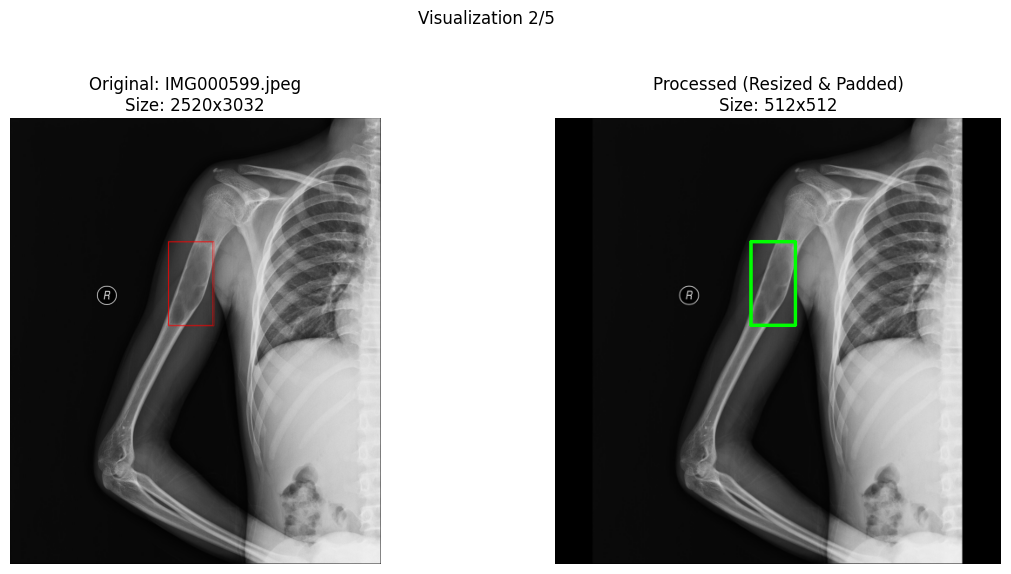

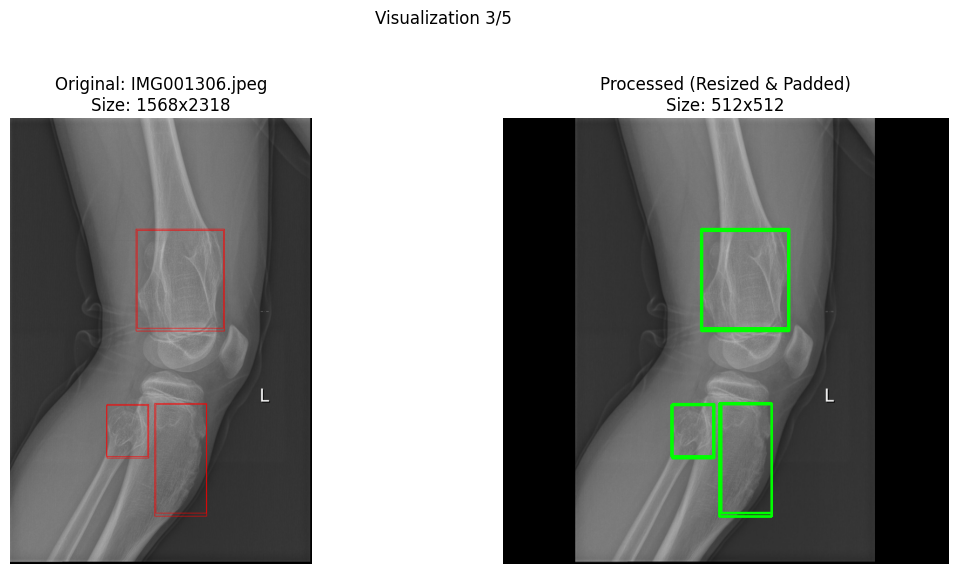

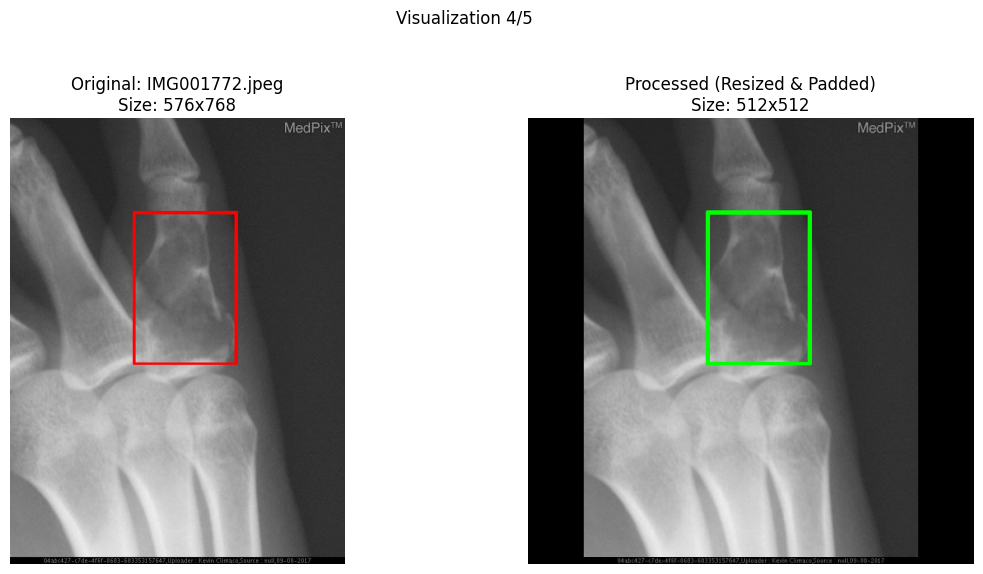

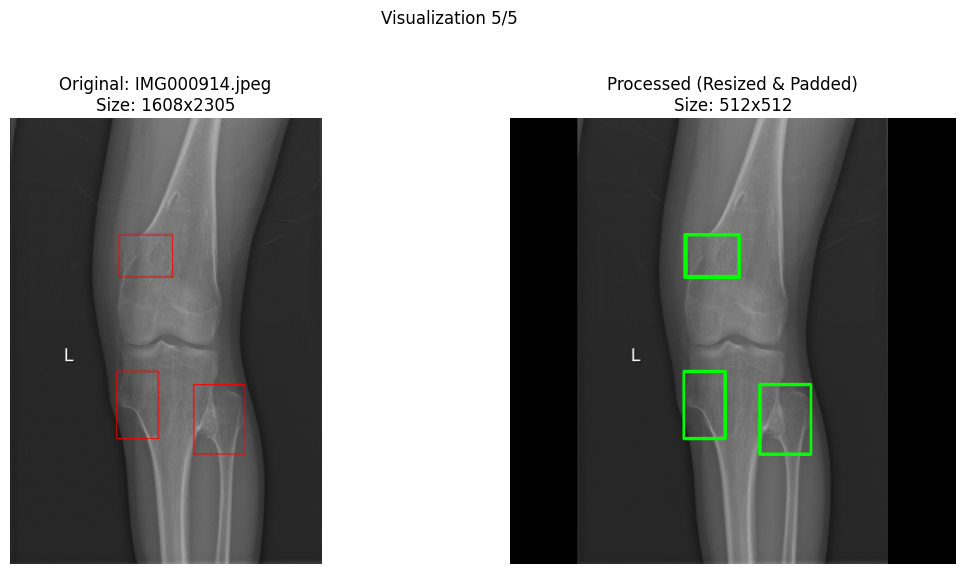

Xử lý 3746 ảnh.
Hiển thị 5 ảnh trực quan hóa.


In [7]:

TARGET_SIZE = 512

# base_input_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD" # Đường dẫn gốc chứa ảnh và annotation
# image_dir = os.path.join(base_input_dir, "images")      # Thư mục chứa ảnh gốc
# annotation_dir = os.path.join(base_input_dir, "Annotations") # Thư mục chứa annotation gốc

output_dir = "/kaggle/working/btxrd-v2.2"
output_image_dir = os.path.join(output_dir, "images")
output_anno_dir = os.path.join(output_dir, "annotations")

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_anno_dir, exist_ok=True)

MAX_VISUALIZATIONS = 5 # Số lượng ảnh tối đa để trực quan hóa
visualized_count = 0


def get_bounding_box(points):
    if not points:
        return None
    points_array = np.array(points)
    xmin = int(np.min(points_array[:, 0]))
    ymin = int(np.min(points_array[:, 1]))
    xmax = int(np.max(points_array[:, 0]))
    ymax = int(np.max(points_array[:, 1]))
    # Đảm bảo tọa độ không âm
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    return (xmin, ymin, xmax, ymax)

try:
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg'))]
    total_images = len(image_files)
    if total_images == 0:
        print(f"Không tìm thấy file ảnh nào trong: {image_dir}")
        exit()
    print(f"Tìm thấy {total_images} ảnh để xử lý.")
except FileNotFoundError:
    print(f"Không tìm thấy thư mục ảnh: {image_dir}")
    exit()

print(f"Bắt đầu xử lý ảnh và lưu vào: {output_dir}")
# Sử dụng tqdm để hiển thị thanh tiến trình
for file in tqdm(image_files, desc="Processing Images"):
    img_path = os.path.join(image_dir, file)
    anno_filename = file.rsplit('.', 1)[0] + '.json'
    anno_path = os.path.join(annotation_dir, anno_filename)

    # Đọc ảnh gốc
    img_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_orig is None:
        # print(f"Không thể đọc ảnh: {file}"
        continue
    orig_height, orig_width = img_orig.shape[:2]

    # Đọc annotation gốc 
    annotation_orig = None
    has_annotation = os.path.exists(anno_path)
    if has_annotation:
        try:
            with open(anno_path, "r", encoding="utf-8") as f:
                annotation_orig = json.load(f)
        except Exception as e:
            # print(f"Lỗi khi đọc annotation {anno_filename}: {e}")
            has_annotation = False # Coi như không có nếu đọc lỗi

    img_to_draw_orig = None
    img_to_draw_padded = None
    original_bboxes = []
    transformed_bboxes = []

    should_visualize = has_annotation and (visualized_count < MAX_VISUALIZATIONS)

    if should_visualize:
        img_to_draw_orig = cv2.cvtColor(img_orig, cv2.COLOR_GRAY2BGR) # Chuyển sang BGR để vẽ màu
        if annotation_orig and "shapes" in annotation_orig:
             for shape in annotation_orig["shapes"]:
                if shape.get("shape_type") == "rectangle" and "points" in shape and len(shape["points"]) == 2:
                     # LabelMe rectangle format uses [top-left, bottom-right]
                     p1 = shape["points"][0]
                     p2 = shape["points"][1]
                     xmin = int(min(p1[0], p2[0]))
                     ymin = int(min(p1[1], p2[1]))
                     xmax = int(max(p1[0], p2[0]))
                     ymax = int(max(p1[1], p2[1]))
                     bbox = (max(0, xmin), max(0, ymin), xmax, ymax)
                     original_bboxes.append(bbox)
                     cv2.rectangle(img_to_draw_orig, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2) # Vẽ màu đỏ (BGR)
                elif shape.get("shape_type") in ["polygon", "linestrip", "point"] and "points" in shape and shape["points"]:
                     # Lấy bounding box bao quanh các loại shape khác
                     bbox = get_bounding_box(shape["points"])
                     if bbox:
                        original_bboxes.append(bbox)
                        cv2.rectangle(img_to_draw_orig, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2) # Red

    # Resize ảnh với padding để giữ tỉ lệ
    # Tính tỉ lệ resize để cạnh dài nhất bằng TARGET_SIZE
    scale = TARGET_SIZE / max(orig_height, orig_width)
    new_width = int(orig_width * scale)
    new_height = int(orig_height * scale)

    # Đảm bảo kích thước mới không lớn hơn TARGET_SIZE
    new_width = min(new_width, TARGET_SIZE)
    new_height = min(new_height, TARGET_SIZE)

    # Resize ảnh
    img_resized = cv2.resize(img_orig, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Tính toán padding
    pad_h = TARGET_SIZE - new_height
    pad_w = TARGET_SIZE - new_width
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    # Thêm padding
    # Sử dụng giá trị 0 (màu đen) cho padding vì ảnh là grayscale
    padded_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    # Lưu ảnh đã xử lý
    output_img_path = os.path.join(output_image_dir, file)
    try:
        # Đảm bảo kích thước cuối cùng đúng là TARGET_SIZE x TARGET_SIZE
        if padded_img.shape[0] != TARGET_SIZE or padded_img.shape[1] != TARGET_SIZE:
             # Nếu có sai lệch nhỏ do làm tròn, resize lại lần cuối
             padded_img = cv2.resize(padded_img, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)
             # print(f"Final resize needed for {file}. Original: ({orig_width}x{orig_height}), Resized: ({new_width}x{new_height}), Padded: {padded_img.shape[:2]}")


        cv2.imwrite(output_img_path, padded_img)
    except Exception as e:
        # print(f"Lỗi khi lưu ảnh {output_img_path}: {e}") # Bỏ comment nếu cần debug
        continue # Bỏ qua ảnh này nếu không lưu được

    # Xử lý và lưu annotation
    if has_annotation and annotation_orig:
        # Tạo bản sao sâu để không ảnh hưởng annotation gốc
        annotation_new = json.loads(json.dumps(annotation_orig))

        if "shapes" in annotation_new:
            new_shapes = [] # Tạo list mới để chứa các shape đã chuyển đổi
            for shape in annotation_new["shapes"]:
                if "points" in shape and shape["points"]:
                    original_points = shape["points"]
                    new_points_transformed = []
                    valid_shape = True
                    for x, y in original_points:
                        # Áp dụng tỉ lệ resize
                        new_x = x * scale
                        new_y = y * scale
                        # Áp dụng padding offset
                        new_x += left
                        new_y += top

                        # Kiểm tra xem điểm có nằm trong ảnh mới không
                        # new_x = max(0, min(TARGET_SIZE - 1, new_x))
                        # new_y = max(0, min(TARGET_SIZE - 1, new_y))
                        new_points_transformed.append([new_x, new_y])

                    # Cập nhật điểm trong shape
                    shape["points"] = new_points_transformed
                    new_shapes.append(shape) # Thêm shape đã chuyển đổi vào list mới

                    # Tính bbox mới để trực quan hóa
                    if should_visualize:
                        new_bbox = get_bounding_box(new_points_transformed)
                        if new_bbox:
                            # Đảm bảo bbox không vượt ra ngoài TARGET_SIZE
                            xmin = max(0, min(TARGET_SIZE - 1, new_bbox[0]))
                            ymin = max(0, min(TARGET_SIZE - 1, new_bbox[1]))
                            xmax = max(0, min(TARGET_SIZE - 1, new_bbox[2]))
                            ymax = max(0, min(TARGET_SIZE - 1, new_bbox[3]))
                            # Chỉ thêm vào nếu bbox hợp lệ
                            if xmax > xmin and ymax > ymin:
                                transformed_bboxes.append((xmin, ymin, xmax, ymax))

            # Cập nhật lại danh sách shapes và kích thước ảnh trong annotation
            annotation_new["shapes"] = new_shapes
            annotation_new["imagePath"] = file # Cập nhật tên file ảnh mới
            annotation_new["imageWidth"] = TARGET_SIZE
            annotation_new["imageHeight"] = TARGET_SIZE
            
            if "imageData" in annotation_new:
                annotation_new["imageData"] = None

            # Lưu file annotation mới
            output_annotation_path = os.path.join(output_anno_dir, anno_filename)
            try:
                with open(output_annotation_path, "w", encoding="utf-8") as f:
                    json.dump(annotation_new, f, indent=4, ensure_ascii=False)
            except Exception as e:
                # print(f"Lỗi khi lưu annotation {anno_filename}: {e}") # Bỏ comment nếu cần debug
                pass # Bỏ qua nếu lưu lỗi

            if should_visualize and img_to_draw_orig is not None:
                # Chuyển ảnh đã padding sang BGR để vẽ màu
                img_to_draw_padded = cv2.cvtColor(padded_img, cv2.COLOR_GRAY2BGR)
                # Vẽ các bounding box đã biến đổi
                for bbox in transformed_bboxes:
                     # Đảm bảo tọa độ là số nguyên để vẽ
                     pt1 = (int(bbox[0]), int(bbox[1]))
                     pt2 = (int(bbox[2]), int(bbox[3]))
                     cv2.rectangle(img_to_draw_padded, pt1, pt2, (0, 255, 0), 2) # Vẽ màu xanh lá (BGR)

                # Hiển thị ảnh gốc và ảnh đã xử lý
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))

                # Ảnh gốc với bbox gốc (màu đỏ)
                axes[0].imshow(cv2.cvtColor(img_to_draw_orig, cv2.COLOR_BGR2RGB)) # Chuyển BGR sang RGB cho matplotlib
                axes[0].set_title(f'Original: {file}\nSize: {orig_width}x{orig_height}')
                axes[0].axis('off')

                # Ảnh đã xử lý với bbox mới (màu xanh)
                axes[1].imshow(cv2.cvtColor(img_to_draw_padded, cv2.COLOR_BGR2RGB)) # Chuyển BGR sang RGB
                axes[1].set_title(f'Processed (Resized & Padded)\nSize: {TARGET_SIZE}x{TARGET_SIZE}')
                axes[1].axis('off')

                plt.suptitle(f"Visualization {visualized_count + 1}/{MAX_VISUALIZATIONS}")
                plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh layout để tiêu đề không bị che
                plt.show()

                visualized_count += 1

print(f"Xử lý {total_images} ảnh.")
if visualized_count > 0:
    print(f"Hiển thị {visualized_count} ảnh trực quan hóa.")

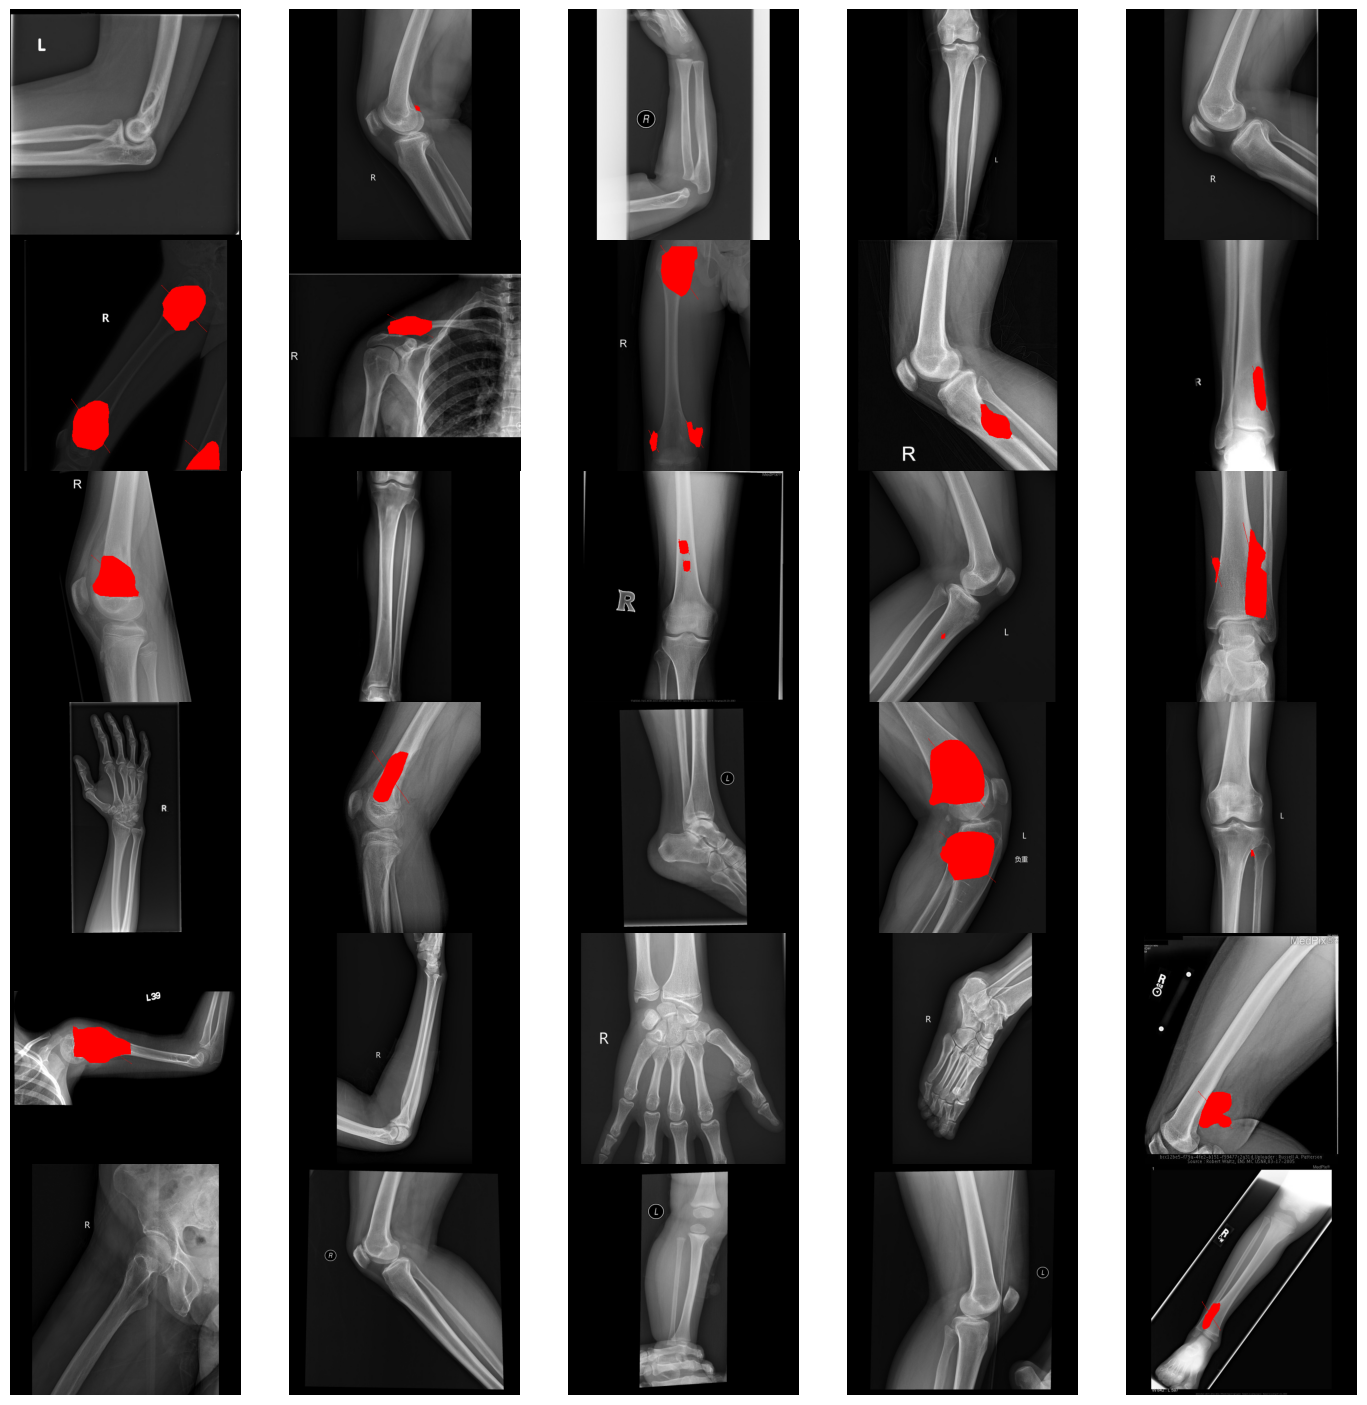

In [8]:
# hiển thị random 30 hình sau khi xử lý ảnh
# Cấu hình
image_dir_test = '/kaggle/working/btxrd-v2.2/images'
annotation_dir_test = '/kaggle/working/btxrd-v2.2/annotations'
# Cấu hình
num_images_to_show = 30
images_per_row = 5  # Số ảnh mỗi hàng
mask_color = [255, 0, 0]  # Red

def create_mask(img_size: Tuple[int, int], ann_path: str) -> np.ndarray:
    mask = Image.new('L', img_size, 0)
    if os.path.exists(ann_path):
        try:
            with open(ann_path, 'r') as f:
                data = json.load(f)
                for shape in data.get('shapes', []):
                    points = shape.get('points', [])
                    polygon_points = [(int(x), int(y)) for x, y in points]
                    if polygon_points:
                        ImageDraw.Draw(mask).polygon(polygon_points, outline=1, fill=1)
        except Exception as e:
            print(f"Lỗi annotation {ann_path}: {e}")
    return np.array(mask)

# Lấy danh sách tất cả ảnh trong thư mục
all_filenames = [f for f in os.listdir(image_dir_test) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Chọn ngẫu nhiên 30 ảnh
selected_filenames = random.sample(all_filenames, min(num_images_to_show, len(all_filenames)))

# Plot ảnh với mask
plt.figure(figsize=(18, 18))  # Tăng kích thước ảnh
for i, fname in enumerate(selected_filenames):
    img_path = os.path.join(image_dir_test, fname)
    ann_fname = os.path.splitext(fname)[0] + '.json'
    ann_path = os.path.join(annotation_dir_test, ann_fname)

    try:
        img_pil = Image.open(img_path).convert('L')
        img_np = np.array(img_pil)

        mask_np = create_mask(img_pil.size, ann_path)
        color_img = np.stack([img_np] * 3, axis=-1)
        color_img[mask_np == 1] = mask_color

        # Chia bố cục thành 6 hàng và 5 cột (số ảnh mỗi hàng là 5)
        plt.subplot(6, 5, i + 1)
        plt.imshow(color_img)
        plt.axis('off')  # Tắt trục
    except Exception as e:
        print(f"Lỗi khi xử lý {fname}: {e}")
        continue

# Loại bỏ khoảng trống giữa các ảnh
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


# **Chia tập dữ liệu**

In [9]:
output_split_dir = "/kaggle/working/btxrd-v2.1"

ANNOTATION_EXTENSION = ".json"

VAL_SIZE = 0.20   # 20% cho tập validation
TRAIN_SIZE = 0.70 # 70% cho tập train
TEST_SIZE = 1.0 - VAL_SIZE - TRAIN_SIZE

RANDOM_STATE = 42

In [10]:
# Đọc Dữ liệu Phân loại từ Excel
try:
    df_classification = pd.read_excel(excel_path)
    required_columns = ['image_id', 'tumor_type', 'image_filename']
    if not all(col in df_classification.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df_classification.columns]
        raise ValueError(f"File Excel thiếu các cột bắt buộc: {missing}")

    df_classification['image_id'] = df_classification['image_id'].astype(str).str.strip()
    df_classification['image_filename'] = df_classification['image_filename'].astype(str).str.strip()

    print(f"Đọc thành công {len(df_classification)} dòng")
    print(df_classification['tumor_type'].value_counts())
except FileNotFoundError:
    print(f"Không tìm thấy file Excel tại {excel_path}")
    exit()
except ValueError as ve:
    print(f"Lỗi dữ liệu trong file Excel: {ve}")
    exit()
except Exception as e:
    print(f"không xác định khi đọc file Excel: {e}")
    exit()

try:
    all_image_files = glob.glob(os.path.join(image_dir_test, "*.*"))
    annotation_files = glob.glob(os.path.join(annotation_dir_test, f"*{ANNOTATION_EXTENSION}"))

    image_basenames_actual = set(os.path.splitext(os.path.basename(f))[0] for f in all_image_files)
    annotation_basenames_actual = set(os.path.splitext(os.path.basename(f))[0] for f in annotation_files)

    print(f"Tìm thấy {len(all_image_files)} tệp")
    print(f"Tìm thấy {len(annotation_files)} tệp annotation")
except Exception as e:
    print(f"Lỗi khi quét thư mục ảnh hoặc annotation: {e}")
    exit()

Đọc thành công 3746 dòng
tumor_type
osteochondroma              754
osteosarcoma                297
multiple osteochondromas    263
simple bone cyst            206
other bt                    115
giant cell tumor             93
synovial osteochondroma      50
other mt                     45
osteofibroma                 44
Name: count, dtype: int64
Tìm thấy 3746 tệp
Tìm thấy 1867 tệp annotation


In [11]:
excel_image_ids = set(df_classification['image_id'])
valid_ids = list(excel_image_ids.intersection(image_basenames_actual).intersection(annotation_basenames_actual))

if not valid_ids:
    print("Không tìm thấy dữ liệu hợp lệ nào.")
    exit()
df_filtered = df_classification[df_classification['image_id'].isin(valid_ids)].copy()
df_filtered = df_filtered.drop_duplicates(subset=['image_id'])
filename_map = pd.Series(df_filtered.image_filename.values, index=df_filtered.image_id).to_dict()


In [12]:
# Chuẩn bị dữ liệu (X=IDs, y=Labels) cho việc chia
X = df_filtered['image_id'].tolist() # Danh sách ID ảnh 
y = df_filtered['tumor_type'].tolist() # Danh sách nhãn tương ứng

# Chia Lần 1 (Train+Val / Test)
X_train_val, X_test, y_train_val, y_test = [], [], [], []
if len(X) < 2:
    print("Không đủ mẫu dữ liệu (< 2) để thực hiện chia.")
    exit()
if TEST_SIZE <= 0 or TEST_SIZE >= 1:
     print(f"Tỷ lệ Test ({TEST_SIZE:.2f}) không hợp lệ. Toàn bộ dữ liệu sẽ là Train+Val.")
     X_train_val, y_train_val = X, y
else:
    try:
        unique_classes_total, counts_total = np.unique(y, return_counts=True)
        stratify_option_1 = y
        if len(unique_classes_total) < 2:
            print("Chỉ có 1 lớp. Chia ngẫu nhiên cho Test.")
            stratify_option_1 = None
        elif np.any(counts_total < 2):
             print(f"Có lớp < 2 mẫu. Chia ngẫu nhiên cho Test.")
             stratify_option_1 = None

        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_option_1
        )
        print(f"Chia lần 1: {len(X_train_val)} Train+Val, {len(X_test)} Test.")
        print("Phân phối 'tumor_type' trong Test:", sorted(Counter(y_test).items()))
    except ValueError as e:
         print(f"Lỗi khi chia lần 1 (Test): {e}. Thoát.")
         exit()


# Chia lần 2 (Train / Validation)
X_train, X_val, y_train, y_val = [], [], [], []
if not X_train_val:
     print("Tập Train+Val rỗng.")
elif len(X_train_val) == 1:
     print("Tập Train+Val chỉ có 1 mẫu -> vào Train.")
     X_train, y_train = X_train_val, y_train_val
elif VAL_SIZE <= 0 or VAL_SIZE >= 1:
     print(f"Tỷ lệ Val ({VAL_SIZE:.4f}) không hợp lệ. Toàn bộ Train+Val -> Train.")
     X_train, y_train = X_train_val, y_train_val
else:
    try:
        unique_classes_tv, counts_tv = np.unique(y_train_val, return_counts=True)
        stratify_option_2 = y_train_val
        if len(unique_classes_tv) < 2:
            print("Train+Val chỉ còn 1 lớp. Chia ngẫu nhiên cho Val.")
            stratify_option_2 = None
        elif np.any(counts_tv < 2):
             print(f"Có lớp < 2 mẫu trong Train+Val. Chia ngẫu nhiên cho Val.")
             stratify_option_2 = None

        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=VAL_SIZE,
            random_state=RANDOM_STATE, stratify=stratify_option_2
        )
        print(f"Chia lần 2: {len(X_train)} Train, {len(X_val)} Validation.")
        print("Phân phối 'tumor_type' trong Train:", sorted(Counter(y_train).items()))
        print("Phân phối 'tumor_type' trong Validation:", sorted(Counter(y_val).items()))
    except ValueError as e:
        print(f"Lỗi khi chia lần 2 (Validation): {e}. Toàn bộ Train+Val -> Train.")
        X_train, y_train = X_train_val, y_train_val # Gán lại vào Train

Chia lần 1: 1680 Train+Val, 187 Test.
Phân phối 'tumor_type' trong Test: [('giant cell tumor', 9), ('multiple osteochondromas', 26), ('osteochondroma', 76), ('osteofibroma', 4), ('osteosarcoma', 30), ('other bt', 12), ('other mt', 4), ('simple bone cyst', 21), ('synovial osteochondroma', 5)]
Chia lần 2: 1344 Train, 336 Validation.
Phân phối 'tumor_type' trong Train: [('giant cell tumor', 67), ('multiple osteochondromas', 190), ('osteochondroma', 542), ('osteofibroma', 32), ('osteosarcoma', 214), ('other bt', 82), ('other mt', 33), ('simple bone cyst', 148), ('synovial osteochondroma', 36)]
Phân phối 'tumor_type' trong Validation: [('giant cell tumor', 17), ('multiple osteochondromas', 47), ('osteochondroma', 136), ('osteofibroma', 8), ('osteosarcoma', 53), ('other bt', 21), ('other mt', 8), ('simple bone cyst', 37), ('synovial osteochondroma', 9)]


In [13]:
# kết quả sau khi chia
total_ids_split = len(X_train) + len(X_val) + len(X_test)
original_valid_count = len(df_filtered)

print(f"Tổng số mẫu hợp lệ ban đầu: {original_valid_count}")
print(f"Tổng số IDs được chia vào các tập: {total_ids_split}")
if total_ids_split != original_valid_count:
     print(f"Số ID được chia ({total_ids_split}) không khớp số ID hợp lệ ({original_valid_count}). Kiểm tra logic chia.")

print(f"Train set IDs:      {len(X_train):>5}")
print(f"Validation set IDs: {len(X_val):>5}")
print(f"Test set IDs:       {len(X_test):>5}")

if total_ids_split > 0:
    print(f"\nTỷ lệ thực tế (dựa trên IDs):")
    print(f"  Train: {len(X_train) / total_ids_split * 100:>6.1f}%")
    print(f"  Val:   {len(X_val) / total_ids_split * 100:>6.1f}%")
    print(f"  Test:  {len(X_test) / total_ids_split * 100:>6.1f}%")

print("\nPhân phối 'tumor_type' cuối cùng (dựa trên IDs đã chia):")
print(f"Train:      {sorted(Counter(y_train).items())}")
print(f"Validation: {sorted(Counter(y_val).items())}")
print(f"Test:       {sorted(Counter(y_test).items())}")

Tổng số mẫu hợp lệ ban đầu: 1867
Tổng số IDs được chia vào các tập: 1867
Train set IDs:       1344
Validation set IDs:   336
Test set IDs:         187

Tỷ lệ thực tế (dựa trên IDs):
  Train:   72.0%
  Val:     18.0%
  Test:    10.0%

Phân phối 'tumor_type' cuối cùng (dựa trên IDs đã chia):
Train:      [('giant cell tumor', 67), ('multiple osteochondromas', 190), ('osteochondroma', 542), ('osteofibroma', 32), ('osteosarcoma', 214), ('other bt', 82), ('other mt', 33), ('simple bone cyst', 148), ('synovial osteochondroma', 36)]
Validation: [('giant cell tumor', 17), ('multiple osteochondromas', 47), ('osteochondroma', 136), ('osteofibroma', 8), ('osteosarcoma', 53), ('other bt', 21), ('other mt', 8), ('simple bone cyst', 37), ('synovial osteochondroma', 9)]
Test:       [('giant cell tumor', 9), ('multiple osteochondromas', 26), ('osteochondroma', 76), ('osteofibroma', 4), ('osteosarcoma', 30), ('other bt', 12), ('other mt', 4), ('simple bone cyst', 21), ('synovial osteochondroma', 5)]


# **Huấn luyện mô hình**

In [3]:
# --- Cấu hình ---
INPUT_DATA_ROOT = '/kaggle/input/btxrd-data' # THAY ĐỔI NẾU MÔI TRƯỜNG CỦA BẠN KHÁC
BASE_DATA_DIR = os.path.join(INPUT_DATA_ROOT, 'btxrd-v2.1')
CLASSIFICATION_FILE = os.path.join(INPUT_DATA_ROOT, 'classification.xlsx')
IMAGE_SUBDIR_NAME = 'images'
ANNOTATION_SUBDIR_NAME = 'annotations'

# Tham số Model & Huấn luyện
TARGET_SIZE = 512
N_CLASSES = 2 # 2 lớp: 0 (nền), 1 (khối u)
BATCH_SIZE = 8
BUFFER_SIZE = 100
EPOCHS = 200 # Tăng epochs, EarlyStopping sẽ xử lý
LEARNING_RATE = 3e-5 #
L2_REG_FACTOR = 1e-5
DROPOUT_RATE = 0.3

# --- Cải tiến để tăng IoU ---
USE_COMBINED_LOSS = True
DICE_LOSS_WEIGHT = 0.6 # Ưu tiên Dice hơn một chút, hoặc giữ 0.5
USE_FOCAL_LOSS_IN_COMBINED = True # **MẶC ĐỊNH SỬ DỤNG FOCAL LOSS**
FOCAL_LOSS_ALPHA = 0.25 # Alpha cho Focal Loss
FOCAL_LOSS_GAMMA = 2.0  # Gamma cho Focal Loss

USE_ATTENTION_UNET = False # Thử nghiệm bật/tắt sau
# USE_ALBUMENTATIONS = False # Tạm thời không dùng để giữ code đơn giản

APPLY_POST_PROCESSING = True
POST_PROCESSING_KERNEL_SIZE = (5,5)
MIN_AREA_POST_PROCESSING = 30

MODEL_CHECKPOINT_BASENAME = "best_unet_model_iou_focused"
TENSORBOARD_LOG_DIR = "./logs_unet_iou_focused"

# --- Các hằng số cho callback ---
PATIENCE_EARLY_STOPPING = 35 # Tăng patience
PATIENCE_REDUCE_LR = 12  # Tăng patience

In [4]:
def get_valid_paths(base_dir: str, split_type: str, img_filename_with_ext: str) -> Optional[Tuple[str, str]]:
    split_dir = os.path.join(base_dir, split_type); image_dir_path = os.path.join(split_dir, IMAGE_SUBDIR_NAME); annotation_dir_path = os.path.join(split_dir, ANNOTATION_SUBDIR_NAME)
    img_path = os.path.join(image_dir_path, img_filename_with_ext); base_name = os.path.splitext(img_filename_with_ext)[0]; json_filename = base_name + '.json'
    json_path = os.path.join(annotation_dir_path, json_filename)
    if os.path.exists(img_path) and os.path.exists(json_path): return img_path, json_path
    return None

def create_mask_pil(mask_size: Tuple[int, int], json_path: str) -> Image.Image:
    if not os.path.exists(json_path): return Image.new('L', (mask_size[1], mask_size[0]), 0)
    mask = Image.new('L', (mask_size[1], mask_size[0]), 0)
    try:
        with open(json_path, 'r') as f: data = json.load(f)
        if 'shapes' not in data or not isinstance(data['shapes'], list) or not data['shapes']: return mask
        for shape in data['shapes']:
             if 'points' in shape and isinstance(shape['points'], list):
                  polygon = [tuple(point) for point in shape['points']]
                  if len(polygon) >= 3: ImageDraw.Draw(mask).polygon(polygon, outline=255, fill=255)
    except (json.JSONDecodeError, Exception): return Image.new('L', (mask_size[1], mask_size[0]), 0)
    return mask

def plot_image(ax: plt.Axes, image_data: np.ndarray, title: str, cmap='gray'):
    if image_data.ndim == 2 or (image_data.ndim == 3 and image_data.shape[2] == 1): ax.imshow(image_data.squeeze(), cmap=cmap)
    else: ax.imshow(image_data)
    ax.set_title(title, fontsize=10); ax.axis('off')

all_image_paths = []; all_mask_paths = []; all_types = []
try:
    if not os.path.exists(CLASSIFICATION_FILE): raise FileNotFoundError(f"Không tìm thấy file phân loại tại {CLASSIFICATION_FILE}")
    if not os.path.isdir(BASE_DATA_DIR): raise FileNotFoundError(f"Không tìm thấy thư mục dữ liệu cơ sở: {BASE_DATA_DIR}")
    df_classification = pd.read_excel(CLASSIFICATION_FILE)
    required_cols = ['image_filename', 'type']
    if not all(col in df_classification.columns for col in required_cols): raise ValueError(f"File Excel phải chứa các cột: {required_cols}")
    for index, row in tqdm(df_classification.iterrows(), total=len(df_classification), desc="Kiểm tra file"):
        img_filename_with_ext = row['image_filename']; file_type = row['type']
        if pd.isna(img_filename_with_ext) or pd.isna(file_type) or file_type not in ['train', 'val', 'test']: continue
        paths = get_valid_paths(BASE_DATA_DIR, str(file_type).lower(), str(img_filename_with_ext))
        if paths: img_path, json_path = paths; all_image_paths.append(img_path); all_mask_paths.append(json_path); all_types.append(str(file_type).lower())
    if not all_image_paths: print("\nLỗi: Không tìm thấy cặp ảnh-chú thích hợp lệ nào."); exit()
    df_paths = pd.DataFrame({'image_path': all_image_paths, 'mask_path': all_mask_paths, 'type': all_types})
    df_train = df_paths[df_paths['type'] == 'train'].reset_index(drop=True); df_val = df_paths[df_paths['type'] == 'val'].reset_index(drop=True); df_test = df_paths[df_paths['type'] == 'test'].reset_index(drop=True)
    train_image_paths = df_train['image_path'].tolist(); train_mask_paths = df_train['mask_path'].tolist()
    val_image_paths = df_val['image_path'].tolist(); val_mask_paths = df_val['mask_path'].tolist()
    test_image_paths = df_test['image_path'].tolist(); test_mask_paths = df_test['mask_path'].tolist()
    print(f"\nPhân chia dữ liệu: Train({len(train_image_paths)}), Val({len(val_image_paths)}), Test({len(test_image_paths)})")
    if not train_image_paths: print("Cảnh báo: Tập huấn luyện rỗng!"); exit()
except Exception as e: print(f"Lỗi khi tải siêu dữ liệu: {e}"); import traceback; traceback.print_exc(); exit()

# Tính toán Mean/Std
mean_pixel = 0.5; std_pixel = 0.1
num_train_images = len(train_image_paths)
if num_train_images > 0:
    print("Đang tính toán Mean/Std...")
    pixel_sum = 0.0; pixel_sum_sq = 0.0; total_pixels_calculated = 0; processed_count = 0
    sample_size_for_stats = min(num_train_images, 250) # Tăng nhẹ sample size
    sampled_train_paths = np.random.choice(train_image_paths, size=sample_size_for_stats, replace=False)
    for img_path in tqdm(sampled_train_paths, desc="Tính Mean/Std"):
        try:
            img_bytes = tf.io.read_file(img_path); img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False, dtype=tf.float32)
            img = tf.image.resize(img, [TARGET_SIZE, TARGET_SIZE])
            pixel_sum += tf.reduce_sum(img).numpy(); pixel_sum_sq += tf.reduce_sum(tf.square(img)).numpy()
            total_pixels_calculated += (TARGET_SIZE * TARGET_SIZE); processed_count += 1
        except Exception: pass
    if processed_count > 0 and total_pixels_calculated > 0:
        mean_pixel = pixel_sum / total_pixels_calculated; variance = (pixel_sum_sq / total_pixels_calculated) - (mean_pixel ** 2)
        std_pixel = np.sqrt(max(variance, 1e-7)); print(f"Mean: {mean_pixel:.4f}, Std Dev: {std_pixel:.4f}")
        if std_pixel < 1e-4: std_pixel = 0.1; print("Std Dev quá thấp, dùng mặc định 0.1.")
    else: print(f"Cảnh báo: Không tính được mean/std, dùng mặc định.")
std_pixel = max(std_pixel, 1e-7)

# Pipeline Dữ liệu TensorFlow
def load_mask_from_json_py(json_path_bytes):
    json_path = json_path_bytes.numpy().decode('utf-8'); pil_mask = create_mask_pil((TARGET_SIZE, TARGET_SIZE), json_path)
    mask_np = np.array(pil_mask, dtype=np.uint8); mask_np = (mask_np > 128).astype(np.uint8)
    return mask_np

@tf.function
def load_and_preprocess(image_path, mask_json_path):
    img_bytes = tf.io.read_file(image_path)
    try: img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False, dtype=tf.float32)
    except tf.errors.InvalidArgumentError:
        try: img = tf.image.decode_png(img_bytes, channels=1, dtype=tf.uint8); img = tf.cast(img, tf.float32) / 255.0
        except tf.errors.InvalidArgumentError: img = tf.image.decode_jpeg(img_bytes, channels=1); img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, [TARGET_SIZE, TARGET_SIZE]); img.set_shape([TARGET_SIZE, TARGET_SIZE, 1])
    mask_np_binary = tf.py_function(func=load_mask_from_json_py, inp=[mask_json_path], Tout=tf.uint8)
    mask_np_binary.set_shape([TARGET_SIZE, TARGET_SIZE])
    mask_onehot = tf.one_hot(tf.cast(mask_np_binary, tf.int32), depth=N_CLASSES, dtype=tf.float32)
    mask_onehot.set_shape([TARGET_SIZE, TARGET_SIZE, N_CLASSES])
    img = (img - mean_pixel) / std_pixel
    return img, mask_onehot

@tf.function
def augment_data_tf(image, mask_onehot):
    combined = tf.concat([image, tf.cast(mask_onehot, image.dtype)], axis=-1) # Nối image và mask (đã cast về dtype của image)
    # Augmentations mạnh hơn một chút
    if tf.random.uniform(()) > 0.5: combined = tf.image.flip_left_right(combined)
    if tf.random.uniform(()) > 0.5: combined = tf.image.flip_up_down(combined)
    
    k_rot = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32) # Xoay 0, 90, 180, 270 độ
    combined = tf.image.rot90(combined, k=k_rot)
    
    # Tách lại
    img_aug = combined[..., :1]
    mask_aug = tf.cast(combined[..., 1:], tf.float32) # Đảm bảo mask là float32
    
    img_aug = tf.image.random_brightness(img_aug, max_delta=0.25) # Tăng dải brightness
    img_aug = tf.image.random_contrast(img_aug, lower=0.7, upper=1.3) # Tăng dải contrast
    
    # Thêm random zoom (cần resize lại sau đó)
    if tf.random.uniform(()) > 0.3: # Áp dụng zoom với xác suất 30%
        scale = tf.random.uniform((), 0.8, 1.2) # Zoom từ 80% đến 120%
        new_height = tf.cast(TARGET_SIZE * scale, tf.int32)
        new_width = tf.cast(TARGET_SIZE * scale, tf.int32)
        
        # Phải augment cả image và mask cùng một cách
        img_scaled = tf.image.resize(img_aug, [new_height, new_width], method=tf.image.ResizeMethod.BILINEAR)
        mask_scaled = tf.image.resize(mask_aug, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # Dùng NEAREST cho mask
        
        # Crop hoặc pad về TARGET_SIZE
        img_aug = tf.image.resize_with_crop_or_pad(img_scaled, TARGET_SIZE, TARGET_SIZE)
        mask_aug = tf.image.resize_with_crop_or_pad(mask_scaled, TARGET_SIZE, TARGET_SIZE)

    img_aug = tf.clip_by_value(img_aug, -3.0, 3.0) # Clip giá trị sau chuẩn hóa và augment
    img_aug.set_shape([TARGET_SIZE, TARGET_SIZE, 1])
    mask_aug.set_shape([TARGET_SIZE, TARGET_SIZE, N_CLASSES])
    return img_aug, mask_aug

def create_dataset(image_paths, mask_paths, is_training=True):
    if not image_paths or not mask_paths: return tf.data.Dataset.from_tensor_slices(([], [])).batch(BATCH_SIZE)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if is_training: dataset = dataset.shuffle(buffer_size=min(BUFFER_SIZE, len(image_paths)), reshuffle_each_iteration=True)
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training: dataset = dataset.map(augment_data_tf, num_parallel_calls=tf.data.AUTOTUNE) # Sử dụng augment_data_tf
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=(is_training if len(image_paths) >= BATCH_SIZE else False))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_image_paths, train_mask_paths, is_training=True)
val_ds = create_dataset(val_image_paths, val_mask_paths, is_training=False)
test_ds = create_dataset(test_image_paths, test_mask_paths, is_training=False)

Kiểm tra file:   0%|          | 0/3746 [00:00<?, ?it/s]


Phân chia dữ liệu: Train(1344), Val(336), Test(187)
Đang tính toán Mean/Std...


Tính Mean/Std:   0%|          | 0/250 [00:00<?, ?it/s]

Mean: 0.1964, Std Dev: 0.2388


In [5]:
# UNET
class AttentionGate(layers.Layer):
    def __init__(self, F_g, F_l, F_int, **kwargs): super(AttentionGate, self).__init__(**kwargs); self.W_g = layers.Conv2D(F_int, 1, padding='same', kernel_initializer='he_normal'); self.W_x = layers.Conv2D(F_int, 1, padding='same', kernel_initializer='he_normal'); self.psi = layers.Conv2D(1, 1, padding='same', kernel_initializer='he_normal', activation='sigmoid'); self.relu = layers.Activation('relu')
    def call(self, g, x): g1 = self.W_g(g); x1 = self.W_x(x); psi_input = self.relu(g1 + x1); alpha = self.psi(psi_input); return x * alpha
def conv_block(inputs, num_filters, l2_reg, dropout):
    x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(inputs); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    return x
def encoder_block(inputs, num_filters, l2_reg, dropout, pool=True): c = conv_block(inputs, num_filters, l2_reg, dropout); p = layers.MaxPooling2D(2)(c) if pool else None; return c, p
def decoder_block(inputs, skip_features, num_filters, l2_reg, dropout, use_attention):
    x = layers.Conv2DTranspose(num_filters, 2, strides=2, padding='same')(inputs)
    if use_attention and skip_features is not None: att_gate = AttentionGate(num_filters, skip_features.shape[-1], max(1, skip_features.shape[-1] // 2) ); skip_features = att_gate(g=x, x=skip_features)
    if skip_features is not None: x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, l2_reg, dropout); return x
def build_unet(input_shape, n_classes=N_CLASSES, l2_reg=L2_REG_FACTOR, dropout=DROPOUT_RATE, use_attention=USE_ATTENTION_UNET):
    filters = [32, 64, 128, 256, 512, 1024] # Giữ nguyên số filter
    inputs = keras.Input(shape=input_shape); skips = []; x = inputs
    for f in filters[:-1]: s, p = encoder_block(x, f, l2_reg, dropout, pool=True); skips.append(s); x = p
    x, _ = encoder_block(x, filters[-1], l2_reg, dropout*1.3, pool=False) # Tăng nhẹ dropout ở bottleneck
    for i, f in reversed(list(enumerate(filters[:-1]))): x = decoder_block(x, skips[i], f, l2_reg, dropout, use_attention)
    outputs = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x)
    return keras.Model(inputs, outputs, name=f"{'Attention' if use_attention else ''}UNet_filters{filters[0]}")

# --- HÀM MẤT MÁT (LOSS FUNCTIONS) ---
SMOOTH = 1e-6
def dice_coef(y_true_one_hot, y_pred_softmax): y_true_f = tf.keras.backend.flatten(y_true_one_hot); y_pred_f = tf.keras.backend.flatten(y_pred_softmax); intersection = tf.keras.backend.sum(y_true_f * y_pred_f); return (2. * intersection + SMOOTH) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + SMOOTH)
def dice_coef_metric_tumor(y_true, y_pred): return dice_coef(y_true[..., 1], y_pred[..., 1]) if N_CLASSES >= 2 else 0.0
def dice_loss_tumor(y_true, y_pred): return 1.0 - dice_coef(y_true[..., 1], y_pred[..., 1]) if N_CLASSES >= 2 else 0.0

def categorical_focal_loss_wrapper(alpha=FOCAL_LOSS_ALPHA, gamma=FOCAL_LOSS_GAMMA): # Đổi tên để tránh xung đột
    def focal_loss_fn(y_true, y_pred): # y_true one-hot, y_pred softmax
        epsilon = tf.keras.backend.epsilon(); y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1)) # Mean over batch & spatial
    focal_loss_fn.__name__ = f'focal_loss_alpha{alpha}_gamma{gamma}' # Đặt tên cho hàm loss
    return focal_loss_fn

def combined_loss_fn(y_true, y_pred, dice_w=DICE_LOSS_WEIGHT):
    d_loss = dice_loss_tumor(y_true, y_pred)
    if USE_FOCAL_LOSS_IN_COMBINED: ce_or_focal_loss = categorical_focal_loss_wrapper()(y_true, y_pred)
    else: ce_or_focal_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred)) # CCE cần reduce_mean
    return (dice_w * d_loss) + ((1.0 - dice_w) * ce_or_focal_loss)
combined_loss_fn.__name__ = f'combined_dice{DICE_LOSS_WEIGHT}_{"focal" if USE_FOCAL_LOSS_IN_COMBINED else "cce"}'

In [6]:
model = build_unet((TARGET_SIZE, TARGET_SIZE, 1))
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

Model: "UNet_filters32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 32)   │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 64)   │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)       

 Total params: 31,118,018 (118.71 MB)

 Trainable params: 31,105,986 (118.66 MB)

 Non-trainable params: 12,032 (47.00 KB)

In [7]:
loss_to_use_obj = combined_loss_fn if USE_COMBINED_LOSS else \
                  (categorical_focal_loss_wrapper() if USE_FOCAL_LOSS_IN_COMBINED else tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.01)) # Thêm label smoothing cho CCE nếu dùng riêng
loss_name_str = getattr(loss_to_use_obj, '__name__', 'UnknownLoss')
print(f"Sử dụng Loss: {loss_name_str}")

tumor_iou_metric = tf.keras.metrics.OneHotIoU(num_classes=N_CLASSES, target_class_ids=[1], name='tumor_iou')
mean_iou_all_metric = tf.keras.metrics.MeanIoU(num_classes=N_CLASSES, name='mean_iou_all')
metrics_list = [
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    mean_iou_all_metric,                             
    tumor_iou_metric,                               
    dice_coef_metric_tumor,                          
    tf.keras.metrics.Precision(class_id=1, name='precision_tumor'), 
    tf.keras.metrics.Recall(class_id=1, name='recall_tumor'),      
]
model.compile(optimizer=optimizer, loss=loss_to_use_obj, metrics=metrics_list)


Sử dụng Loss: combined_dice0.6_focal


In [8]:
# Callbacks
MONITOR_METRIC_CB = 'val_dice_coef_metric_tumor' # Hoặc 'val_tumor_iou'
checkpoint_path = f"{MODEL_CHECKPOINT_BASENAME}_{loss_name_str}_attn{USE_ATTENTION_UNET}.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor=MONITOR_METRIC_CB, mode='max', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor=MONITOR_METRIC_CB, patience=PATIENCE_EARLY_STOPPING, mode='max', restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR_METRIC_CB, factor=0.3, patience=PATIENCE_REDUCE_LR, mode='max', min_lr=1e-7, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=TENSORBOARD_LOG_DIR, histogram_freq=1)
]


In [9]:
#Class Weights
pix_cls0 = 0; pix_cls1 = 0
for mask_p in tqdm(train_mask_paths, desc="Đếm pixels"):
    try: m = create_mask_pil((TARGET_SIZE, TARGET_SIZE), mask_p); m_np = (np.array(m) > 128).astype(np.uint8); pix_cls0 += np.sum(m_np == 0); pix_cls1 += np.sum(m_np == 1)
    except: continue
class_weights = None
if pix_cls1 > 0 and pix_cls0 > 0:
    total_pix = float(pix_cls0 + pix_cls1) # Đảm bảo float division
    # Công thức: scaling_factor / count. Scaling_factor có thể là total_samples / num_classes
    # Hoặc đơn giản là tổng số pixel chia cho số pixel của lớp đó, rồi chuẩn hóa nhẹ.
    # Weight cao hơn cho lớp ít pixel hơn.
    w0 = (total_pix / (N_CLASSES * float(pix_cls0)))
    w1 = (total_pix / (N_CLASSES * float(pix_cls1)))
    
    # Chuẩn hóa lại để tổng weight không quá lớn, giữ cho loss ở mức hợp lý
    # scale_factor = 1.0 / (w0 + w1) # Hoặc một hằng số khác
    # w0 *= scale_factor * N_CLASSES
    # w1 *= scale_factor * N_CLASSES
    
    class_weights = {0: w0, 1: w1}
    print(f"Class weights đã tính: Lớp 0: {w0:.4f}, Lớp 1: {w1:.4f}")
    if w1 < w0 : print("Trọng số lớp khối u (1) nhỏ hơn lớp nền (0). Kiểm tra lại số lượng pixel hoặc dữ liệu.")
else: print("Không tính được class weights (số pixel lớp 0 hoặc 1 bằng 0). Sử dụng None.")



Đếm pixels:   0%|          | 0/1344 [00:00<?, ?it/s]

Class weights đã tính: Lớp 0: 0.5089, Lớp 1: 28.6592


In [10]:
# Huấn luyện Model 
history = None
if train_ds and (not val_image_paths or val_ds):
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds if val_image_paths else None, callbacks=callbacks, class_weight=class_weights) # **SỬ DỤNG CLASS_WEIGHTS**
    print("\nHuấn luyện hoàn tất.")
else: print("Dữ liệu không hợp lệ.")


Epoch 1/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - acc: 0.7337 - dice_coef_metric_tumor: 0.0400 - loss: 0.7201 - mean_iou_all: 0.2510 - precision_tumor: 0.0320 - recall_tumor: 0.4747 - tumor_iou: 0.0713
Epoch 1: val_dice_coef_metric_tumor improved from -inf to 0.04799, saving model to best_unet_model_iou_focused_combined_dice0.6_focal_attnFalse.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 136s 475ms/step - acc: 0.7339 - dice_coef_metric_tumor: 0.0400 - loss: 0.7200 - mean_iou_all: 0.2510 - precision_tumor: 0.0320 - recall_tumor: 0.4750 - tumor_iou: 0.0717 - val_acc: 0.7721 - val_dice_coef_metric_tumor: 0.0480 - val_loss: 0.6858 - val_mean_iou_all: 0.2500 - val_precision_tumor: 0.0563 - val_recall_tumor: 0.8192 - val_tumor_iou: 0.0648 - learning_rate: 3.0000e-05
Epoch 2/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - acc: 0.8019 - dice_coef_metric_tumor: 0.0572 - loss: 0.6866 - mean_iou_all: 0.2511 - precision_tumor: 0.0625 - recall_tumor: 0.6990 - tumor_iou: 0.1067
Epoch 2: val_dice_coef_

In [ ]:
# --- Vẽ biểu đồ (Giữ nguyên) ---
if history:
    print("Vẽ biểu đồ lịch sử huấn luyện..."); plt.figure(figsize=(20, 12))
    metrics_to_plot = {'Loss': ('loss', 'val_loss'), 'Accuracy': ('acc', 'val_acc'), 'Mean IoU (All)': ('mean_iou_all', 'val_mean_iou_all'),
                       'Tumor IoU': ('tumor_iou', 'val_tumor_iou'), 'Dice Coef (Tumor)': ('dice_coef_metric_tumor', 'val_dice_coef_metric_tumor'),
                       'Precision (Tumor)': ('precision_tumor', 'val_precision_tumor'), 'Recall (Tumor)': ('recall_tumor', 'val_recall_tumor')}
    for i, (title, (train_key, val_key)) in enumerate(metrics_to_plot.items()):
        plt.subplot(3, 3, i + 1)
        if train_key in history.history: plt.plot(history.history[train_key], label=f'Train {title}')
        if val_key in history.history: plt.plot(history.history[val_key], label=f'Val {title}')
        plt.title(title); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

In [ ]:
# # Post-processing
# def apply_post_processing_mask(mask_np_binary: np.ndarray, kernel_size: Tuple[int, int] = POST_PROCESSING_KERNEL_SIZE, min_area_threshold: Optional[int] = MIN_AREA_POST_PROCESSING) -> np.ndarray:
#     processed_mask = mask_np_binary.astype(np.uint8); kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
#     processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_OPEN, kernel, iterations=1)
#     processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
#     if min_area_threshold and min_area_threshold > 0:
#         num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(processed_mask, connectivity=8)
#         output_mask = np.zeros_like(processed_mask);
#         for i in range(1, num_labels):
#             if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold: output_mask[labels == i] = 1
#         processed_mask = output_mask
#     return processed_mask.astype(np.uint8)

# # Đánh giá trên tập test
# if os.path.exists(checkpoint_path) and test_ds and test_image_paths:
#     print(f"Tải model tốt nhất từ: {checkpoint_path}")
#     try:
#         custom_objects_load = {'dice_coef_metric_tumor': dice_coef_metric_tumor, 'tumor_iou': tumor_iou_metric, 'mean_iou_all': mean_iou_all_metric}
#         # Thêm hàm loss đã được sử dụng vào custom_objects
#         # Cần đảm bảo tên hàm và các tham số (alpha, gamma cho focal) là giống hệt lúc compile
#         if USE_COMBINED_LOSS:
#             # Cần một cách để reconstruct combined_loss_fn với đúng các tham số nếu nó không được Keras tự động serialize
#             # Cách đơn giản là định nghĩa lại nó hoặc nếu hàm loss có __name__ và Keras lưu theo tên.
#             # Nếu loss_to_use_obj là một hàm, Keras có thể lưu theo tên.
#             custom_objects_load[loss_name_str] = loss_to_use_obj # Thử thêm đối tượng hàm loss trực tiếp
#         elif USE_FOCAL_LOSS_IN_COMBINED: # Trường hợp này đã được bao gồm ở trên nếu USE_COMBINED_LOSS=True
#              custom_objects_load[loss_name_str] = categorical_focal_loss_wrapper(alpha=FOCAL_LOSS_ALPHA, gamma=FOCAL_LOSS_GAMMA)
#         # Nếu chỉ dùng CCE, thường không cần thêm vào custom_objects trừ khi có tùy chỉnh đặc biệt

#         if USE_ATTENTION_UNET: custom_objects_load['AttentionGate'] = AttentionGate

#         best_model = tf.keras.models.load_model(checkpoint_path, custom_objects=custom_objects_load, compile=True) # compile=True rất quan trọng
#         eval_results = best_model.evaluate(test_ds, verbose=1)
#         print("\n--- KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ---")
#         results_dict = dict(zip(best_model.metrics_names, eval_results))
#         for name, val in results_dict.items(): print(f" - Test {name}: {val:.4f}")
#         if 'precision_tumor' in results_dict and 'recall_tumor' in results_dict:
#             p, r = results_dict['precision_tumor'], results_dict['recall_tumor']
#             f1 = 2 * (p * r) / (p + r + SMOOTH) if (p + r) > 0 else 0.0; print(f" - Test F1-Score (Tumor): {f1:.4f}")
#         print("--------------------------------------")
#         # (Phần trực quan hóa giữ nguyên như trước)
#         print("\nTrực quan hóa dự đoán...")
#         num_viz = min(6, len(test_image_paths));
#         if num_viz > 0:
#             cols_viz = 4; title_pad = 1.5
#             if APPLY_POST_PROCESSING: cols_viz += 1; title_pad = 2.0
#             plt.figure(figsize=(cols_viz * 4, num_viz * 4)); test_iter = iter(test_ds.unbatch().take(num_viz))
#             for i in range(num_viz):
#                 try: img_tensor, mask_onehot_tensor = next(test_iter)
#                 except StopIteration: break
#                 img_np = img_tensor.numpy(); pred_probs = best_model.predict(np.expand_dims(img_np, axis=0))[0]
#                 pred_labels = np.argmax(pred_probs, axis=-1).astype(np.uint8); true_labels = np.argmax(mask_onehot_tensor.numpy(), axis=-1).astype(np.uint8)
#                 tumor_prob_map = pred_probs[..., 1]; img_display = np.clip((img_np * std_pixel) + mean_pixel, 0.0, 1.0)
#                 plot_idx = i * cols_viz
#                 plt.subplot(num_viz, cols_viz, plot_idx + 1); plot_image(plt.gca(), img_display, f"Test {i+1}")
#                 plt.subplot(num_viz, cols_viz, plot_idx + 2); plot_image(plt.gca(), true_labels, "Mask Thực tế")
#                 ax_prob = plt.subplot(num_viz, cols_viz, plot_idx + 3); im_prob = ax_prob.imshow(tumor_prob_map, cmap='viridis', vmin=0, vmax=1); ax_prob.set_title("Xác suất Khối u", fontsize=10); ax_prob.axis('off'); plt.colorbar(im_prob, ax=ax_prob, fraction=0.046, pad=0.04)
#                 plt.subplot(num_viz, cols_viz, plot_idx + 4); plot_image(plt.gca(), pred_labels, "Mask Dự đoán (Raw)")
#                 if APPLY_POST_PROCESSING: post_pred = apply_post_processing_mask(pred_labels); plt.subplot(num_viz, cols_viz, plot_idx + 5); plot_image(plt.gca(), post_pred, "Mask (Post-processed)")
#             plt.tight_layout(pad=title_pad); plt.show()
#     except Exception as e: print(f"Lỗi khi tải model/trực quan hóa: {e}"); traceback.print_exc()
# elif not os.path.exists(checkpoint_path): print(f"Checkpoint '{checkpoint_path}' không tìm thấy.")
# else: print("Dataset test rỗng hoặc không hợp lệ.")

thử từ đây

In [ ]:
# -*- coding: utf-8 -*-
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw
from typing import List, Tuple, Optional
import cv2 # For post-processing

# Tùy chọn: Sử dụng Albumentations cho augmentation mạnh mẽ hơn
# import albumentations as A # Bỏ comment nếu muốn sử dụng và đã cài đặt: pip install albumentations

# --- Cấu hình ---
INPUT_DATA_ROOT = '/kaggle/input/btxrd-data' # THAY ĐỔI NẾU MÔI TRƯỜNG CỦA BẠN KHÁC
BASE_DATA_DIR = os.path.join(INPUT_DATA_ROOT, 'btxrd-v2.1')
CLASSIFICATION_FILE = os.path.join(INPUT_DATA_ROOT, 'classification.xlsx')
IMAGE_SUBDIR_NAME = 'images'
ANNOTATION_SUBDIR_NAME = 'annotations'

# Tham số Model & Huấn luyện
TARGET_SIZE = 512
N_CLASSES = 2 # 2 lớp: 0 (nền), 1 (khối u)
BATCH_SIZE = 8
BUFFER_SIZE = 100
EPOCHS = 50 # Tăng epochs, EarlyStopping sẽ xử lý dừng sớm
LEARNING_RATE = 3e-5 # Thử LR nhỏ hơn
L2_REG_FACTOR = 1e-5
DROPOUT_RATE = 0.3 # Có thể tăng nhẹ dropout nếu overfitting

# --- Cải tiến ---
USE_COMBINED_LOSS = True
DICE_LOSS_WEIGHT = 0.5 # Cân bằng hơn giữa Dice và CE/Focal
USE_FOCAL_LOSS_IN_COMBINED = False # Đặt True để thử Focal Loss thay vì CCE
FOCAL_LOSS_ALPHA = 0.25 # Tham số alpha cho Focal Loss (thường dùng khi class imbalance)
FOCAL_LOSS_GAMMA = 2.0  # Tham số gamma cho Focal Loss

USE_ATTENTION_UNET = False # Thử nghiệm bật/tắt
USE_ALBUMENTATIONS = False # Đặt True để sử dụng Albumentations

APPLY_POST_PROCESSING = True
POST_PROCESSING_KERNEL_SIZE = (5,5)
MIN_AREA_POST_PROCESSING = 30 # Tăng nhẹ ngưỡng

MODEL_CHECKPOINT_BASENAME = "best_unet_model_improved_heatmap"
TENSORBOARD_LOG_DIR = "./logs_unet_improved_heatmap"

# --- Các hằng số cho callback ---
PATIENCE_EARLY_STOPPING = 30 # Tăng patience
PATIENCE_REDUCE_LR = 10  # Tăng patience

# --- Hàm trợ giúp (Giữ nguyên get_valid_paths, create_mask_pil, plot_image) ---
def get_valid_paths(base_dir: str, split_type: str, img_filename_with_ext: str) -> Optional[Tuple[str, str]]:
    split_dir = os.path.join(base_dir, split_type)
    image_dir_path = os.path.join(split_dir, IMAGE_SUBDIR_NAME)
    annotation_dir_path = os.path.join(split_dir, ANNOTATION_SUBDIR_NAME)
    img_path = os.path.join(image_dir_path, img_filename_with_ext)
    base_name = os.path.splitext(img_filename_with_ext)[0]
    json_filename = base_name + '.json'
    json_path = os.path.join(annotation_dir_path, json_filename)
    if os.path.exists(img_path) and os.path.exists(json_path):
        return img_path, json_path
    return None

def create_mask_pil(mask_size: Tuple[int, int], json_path: str) -> Image.Image:
    if not os.path.exists(json_path): return Image.new('L', (mask_size[1], mask_size[0]), 0)
    mask = Image.new('L', (mask_size[1], mask_size[0]), 0)
    try:
        with open(json_path, 'r') as f: data = json.load(f)
        if 'shapes' not in data or not isinstance(data['shapes'], list) or not data['shapes']: return mask
        for shape in data['shapes']:
             if 'points' in shape and isinstance(shape['points'], list):
                  polygon = [tuple(point) for point in shape['points']]
                  if len(polygon) >= 3: ImageDraw.Draw(mask).polygon(polygon, outline=255, fill=255)
    except (json.JSONDecodeError, Exception): return Image.new('L', (mask_size[1], mask_size[0]), 0)
    return mask

def plot_image(ax: plt.Axes, image_data: np.ndarray, title: str, cmap='gray'):
    if image_data.ndim == 2 or (image_data.ndim == 3 and image_data.shape[2] == 1):
        ax.imshow(image_data.squeeze(), cmap=cmap)
    else: ax.imshow(image_data)
    ax.set_title(title, fontsize=10); ax.axis('off')

# --- Tải siêu dữ liệu (Giữ nguyên) ---
all_image_paths = []; all_mask_paths = []; all_types = []
try:
    if not os.path.exists(CLASSIFICATION_FILE): raise FileNotFoundError(f"Không tìm thấy file phân loại tại {CLASSIFICATION_FILE}")
    if not os.path.isdir(BASE_DATA_DIR): raise FileNotFoundError(f"Không tìm thấy thư mục dữ liệu cơ sở: {BASE_DATA_DIR}")
    df_classification = pd.read_excel(CLASSIFICATION_FILE)
    required_cols = ['image_filename', 'type']
    if not all(col in df_classification.columns for col in required_cols): raise ValueError(f"File Excel phải chứa các cột: {required_cols}")
    for index, row in tqdm(df_classification.iterrows(), total=len(df_classification), desc="Kiểm tra file"):
        img_filename_with_ext = row['image_filename']; file_type = row['type']
        if pd.isna(img_filename_with_ext) or pd.isna(file_type) or file_type not in ['train', 'val', 'test']: continue
        paths = get_valid_paths(BASE_DATA_DIR, str(file_type).lower(), str(img_filename_with_ext))
        if paths: img_path, json_path = paths; all_image_paths.append(img_path); all_mask_paths.append(json_path); all_types.append(str(file_type).lower())
    if not all_image_paths: print("\nLỗi: Không tìm thấy cặp ảnh-chú thích hợp lệ nào."); exit()
    df_paths = pd.DataFrame({'image_path': all_image_paths, 'mask_path': all_mask_paths, 'type': all_types})
    df_train = df_paths[df_paths['type'] == 'train'].reset_index(drop=True); df_val = df_paths[df_paths['type'] == 'val'].reset_index(drop=True); df_test = df_paths[df_paths['type'] == 'test'].reset_index(drop=True)
    train_image_paths = df_train['image_path'].tolist(); train_mask_paths = df_train['mask_path'].tolist()
    val_image_paths = df_val['image_path'].tolist(); val_mask_paths = df_val['mask_path'].tolist()
    test_image_paths = df_test['image_path'].tolist(); test_mask_paths = df_test['mask_path'].tolist()
    print(f"\nPhân chia dữ liệu: Train({len(train_image_paths)}), Val({len(val_image_paths)}), Test({len(test_image_paths)})")
    if not train_image_paths: print("Cảnh báo: Tập huấn luyện rỗng!"); exit()
except Exception as e: print(f"Lỗi khi tải siêu dữ liệu: {e}"); import traceback; traceback.print_exc(); exit()

# --- Tính toán Mean/Std (Giữ nguyên) ---
mean_pixel = 0.5; std_pixel = 0.1
num_train_images = len(train_image_paths)
if num_train_images > 0:
    print("Đang tính toán Mean/Std...")
    pixel_sum = 0.0; pixel_sum_sq = 0.0; total_pixels_calculated = 0; processed_count = 0
    sample_size_for_stats = min(num_train_images, 200)
    sampled_train_paths = np.random.choice(train_image_paths, size=sample_size_for_stats, replace=False)
    for img_path in tqdm(sampled_train_paths, desc="Tính Mean/Std"):
        try:
            img_bytes = tf.io.read_file(img_path)
            img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False, dtype=tf.float32)
            img = tf.image.resize(img, [TARGET_SIZE, TARGET_SIZE])
            pixel_sum += tf.reduce_sum(img).numpy(); pixel_sum_sq += tf.reduce_sum(tf.square(img)).numpy()
            total_pixels_calculated += (TARGET_SIZE * TARGET_SIZE); processed_count += 1
        except Exception: pass
    if processed_count > 0 and total_pixels_calculated > 0:
        mean_pixel = pixel_sum / total_pixels_calculated
        variance = (pixel_sum_sq / total_pixels_calculated) - (mean_pixel ** 2)
        std_pixel = np.sqrt(max(variance, 1e-7))
        print(f"Mean đã tính: {mean_pixel:.4f}, Std Dev: {std_pixel:.4f}")
        if std_pixel < 1e-4: std_pixel = 0.1; print("Std Dev quá thấp, dùng mặc định 0.1.")
    else: print(f"Cảnh báo: Không tính được mean/std, sử dụng mặc định.")
std_pixel = max(std_pixel, 1e-7)

# --- Pipeline Dữ liệu TensorFlow ---
def load_mask_from_json_py(json_path_bytes):
    json_path = json_path_bytes.numpy().decode('utf-8')
    pil_mask = create_mask_pil((TARGET_SIZE, TARGET_SIZE), json_path)
    mask_np = np.array(pil_mask, dtype=np.uint8); mask_np = (mask_np > 128).astype(np.uint8)
    return mask_np

# --- Augmentation với Albumentations (Tùy chọn) ---
# if USE_ALBUMENTATIONS:
#     print("Sử dụng Albumentations cho Augmentation.")
#     AUGMENTATIONS_TRAIN = A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.RandomRotate90(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=30, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=0),
#         A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
#         A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
#         A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0),
#         # A.GridDistortion(p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0), # Có thể thử
#         # A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0), # Có thể thử
#         A.PadIfNeeded(min_height=TARGET_SIZE, min_width=TARGET_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0), # Đảm bảo kích thước sau augment
#         A.CenterCrop(height=TARGET_SIZE, width=TARGET_SIZE, p=1.0) # Cắt về kích thước target
#     ])
# else:
#     print("Sử dụng tf.image cho Augmentation.")

@tf.function
def load_and_preprocess(image_path, mask_json_path):
    img_bytes = tf.io.read_file(image_path)
    try: img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False, dtype=tf.float32)
    except tf.errors.InvalidArgumentError:
        try: img = tf.image.decode_png(img_bytes, channels=1, dtype=tf.uint8); img = tf.cast(img, tf.float32) / 255.0
        except tf.errors.InvalidArgumentError:
            img = tf.image.decode_jpeg(img_bytes, channels=1); img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, [TARGET_SIZE, TARGET_SIZE]); img.set_shape([TARGET_SIZE, TARGET_SIZE, 1])

    mask_np_binary = tf.py_function(func=load_mask_from_json_py, inp=[mask_json_path], Tout=tf.uint8)
    mask_np_binary.set_shape([TARGET_SIZE, TARGET_SIZE])
    mask_onehot = tf.one_hot(tf.cast(mask_np_binary, tf.int32), depth=N_CLASSES, dtype=tf.float32)
    mask_onehot.set_shape([TARGET_SIZE, TARGET_SIZE, N_CLASSES])

    # Chuẩn hóa ảnh sau khi đã decode và resize
    img = (img - mean_pixel) / std_pixel
    return img, mask_onehot

# @tf.function # Bỏ @tf.function nếu dùng Albumentations vì nó không tương thích trực tiếp
def augment_data_tf(image, mask_onehot): # Đổi tên hàm nếu dùng cả hai
    combined = tf.concat([image, tf.cast(mask_onehot, image.dtype)], axis=-1)
    combined = tf.image.random_flip_left_right(combined)
    combined = tf.image.random_flip_up_down(combined)
    k_rot = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    combined = tf.image.rot90(combined, k=k_rot)
    img_aug = combined[..., :1]
    mask_aug = tf.cast(combined[..., 1:], tf.float32) # Đảm bảo mask là float32
    img_aug = tf.image.random_brightness(img_aug, max_delta=0.2) # Tăng nhẹ dải
    img_aug = tf.image.random_contrast(img_aug, lower=0.75, upper=1.25) # Tăng nhẹ dải
    img_aug = tf.clip_by_value(img_aug, -2.5, 2.5) # Clip sau khi augment
    img_aug.set_shape([TARGET_SIZE, TARGET_SIZE, 1])
    mask_aug.set_shape([TARGET_SIZE, TARGET_SIZE, N_CLASSES])
    return img_aug, mask_aug

# def augment_data_albumentations_py(image_np, mask_np_onehot):
#     # Albumentations cần ảnh uint8 [0-255] và mask nhị phân (H, W) hoặc (H,W,C) cho semantic segmentation
#     # De-normalize image: (image_std * std_pixel_val) + mean_pixel_val
#     image_denorm_np = (image_np * std_pixel) + mean_pixel # std_pixel, mean_pixel phải là giá trị toàn cục
#     image_denorm_np = np.clip(image_denorm_np * 255.0, 0, 255).astype(np.uint8) # Về [0,255] uint8
    
#     # Chuyển mask one-hot về mask nhãn (H,W)
#     mask_labels_np = np.argmax(mask_np_onehot, axis=-1).astype(np.uint8)

#     augmented = AUGMENTATIONS_TRAIN(image=image_denorm_np, mask=mask_labels_np)
#     img_aug_np = augmented['image']
#     mask_aug_labels_np = augmented['mask']

#     # Normalize lại ảnh sau augmentation
#     img_aug_norm_np = (img_aug_np.astype(np.float32) / 255.0 - mean_pixel) / std_pixel
    
#     # Chuyển mask nhãn về lại one-hot
#     mask_aug_onehot_np = tf.one_hot(tf.cast(mask_aug_labels_np, tf.int32), depth=N_CLASSES, dtype=tf.float32).numpy()

#     return img_aug_norm_np.reshape(TARGET_SIZE, TARGET_SIZE, 1), mask_aug_onehot_np

# @tf.function # Sẽ lỗi nếu dùng Albumentations do py_function
# def augment_data(image, mask_onehot):
#     if USE_ALBUMENTATIONS:
#         # Cần tf.py_function để bọc hàm Python dùng Albumentations
#         img_aug, mask_aug = tf.py_function(func=augment_data_albumentations_py,
#                                            inp=[image, mask_onehot],
#                                            Tout=[tf.float32, tf.float32])
#         img_aug.set_shape([TARGET_SIZE, TARGET_SIZE, 1])
#         mask_aug.set_shape([TARGET_SIZE, TARGET_SIZE, N_CLASSES])
#         return img_aug, mask_aug
#     else:
#         return augment_data_tf(image, mask_onehot) # Sử dụng hàm augment tf.image

def create_dataset(image_paths, mask_paths, is_training=True):
    if not image_paths or not mask_paths: return tf.data.Dataset.from_tensor_slices(([], [])).batch(BATCH_SIZE)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if is_training:
        dataset = dataset.shuffle(buffer_size=min(BUFFER_SIZE, len(image_paths)), reshuffle_each_iteration=True)
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        # Quyết định hàm augment nào sẽ được dùng
        # Nếu dùng Albumentations, cần xử lý map với tf.py_function cẩn thận hơn
        # Hiện tại, để đơn giản, tạm thời chỉ dùng tf.image augment
        dataset = dataset.map(augment_data_tf, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=(is_training if len(image_paths) >= BATCH_SIZE else False))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_image_paths, train_mask_paths, is_training=True)
val_ds = create_dataset(val_image_paths, val_mask_paths, is_training=False)
test_ds = create_dataset(test_image_paths, test_mask_paths, is_training=False)

# --- PHẦN U-NET (Giữ nguyên, có thể thử với USE_ATTENTION_UNET = True) ---
class AttentionGate(layers.Layer):
    def __init__(self, F_g, F_l, F_int, **kwargs): super(AttentionGate, self).__init__(**kwargs); self.W_g = layers.Conv2D(F_int, 1, padding='same', kernel_initializer='he_normal'); self.W_x = layers.Conv2D(F_int, 1, padding='same', kernel_initializer='he_normal'); self.psi = layers.Conv2D(1, 1, padding='same', kernel_initializer='he_normal', activation='sigmoid'); self.relu = layers.Activation('relu')
    def call(self, g, x): g1 = self.W_g(g); x1 = self.W_x(x); psi_input = self.relu(g1 + x1); alpha = self.psi(psi_input); return x * alpha

def conv_block(inputs, num_filters, l2_reg, dropout):
    x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    return x

def encoder_block(inputs, num_filters, l2_reg, dropout, pool=True):
    c = conv_block(inputs, num_filters, l2_reg, dropout)
    if pool: p = layers.MaxPooling2D(2)(c); return c, p
    return c, None

def decoder_block(inputs, skip_features, num_filters, l2_reg, dropout, use_attention):
    x = layers.Conv2DTranspose(num_filters, 2, strides=2, padding='same')(inputs)
    if use_attention and skip_features is not None:
        att_gate = AttentionGate(num_filters, skip_features.shape[-1], max(1, skip_features.shape[-1] // 2) ) # Đảm bảo F_int > 0
        skip_features = att_gate(g=x, x=skip_features)
    if skip_features is not None: x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, l2_reg, dropout)
    return x

def build_unet(input_shape, n_classes=N_CLASSES, l2_reg=L2_REG_FACTOR, dropout=DROPOUT_RATE, use_attention=USE_ATTENTION_UNET):
    filters = [64, 128, 256, 512, 1024] # Có thể thử [32, 64, 128, 256, 512] nếu model quá lớn
    inputs = keras.Input(shape=input_shape); skips = []; x = inputs
    for f in filters[:-1]: s, x = encoder_block(x, f, l2_reg, dropout, pool=True); skips.append(s)
    x, _ = encoder_block(x, filters[-1], l2_reg, dropout*1.2, pool=False) # Giảm nhẹ dropout ở bottleneck
    for i, f in reversed(list(enumerate(filters[:-1]))): x = decoder_block(x, skips[i], f, l2_reg, dropout, use_attention)
    outputs = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x)
    return keras.Model(inputs, outputs, name=f"{'Attention' if use_attention else ''}UNet_filters{filters[0]}")

# --- HÀM MẤT MÁT (LOSS FUNCTIONS) ---
SMOOTH = 1e-6
def dice_coef(y_true_one_hot, y_pred_softmax):
    y_true_f = tf.keras.backend.flatten(y_true_one_hot); y_pred_f = tf.keras.backend.flatten(y_pred_softmax)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + SMOOTH)

def dice_coef_metric_tumor(y_true, y_pred): return dice_coef(y_true[..., 1], y_pred[..., 1]) if N_CLASSES >= 2 else 0.0
def dice_loss_tumor(y_true, y_pred): return 1.0 - dice_coef(y_true[..., 1], y_pred[..., 1]) if N_CLASSES >= 2 else 0.0

def categorical_focal_loss(alpha=FOCAL_LOSS_ALPHA, gamma=FOCAL_LOSS_GAMMA):
    def focal_loss(y_true, y_pred): # y_true one-hot, y_pred softmax
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1) # Sum over classes, mean over batch/spatial by default in model.compile
    return focal_loss

def combined_loss_fn(y_true, y_pred, dice_w=DICE_LOSS_WEIGHT):
    d_loss = dice_loss_tumor(y_true, y_pred)
    if USE_FOCAL_LOSS_IN_COMBINED:
        ce_or_focal_loss = categorical_focal_loss()(y_true, y_pred)
    else:
        ce_or_focal_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    ce_or_focal_loss_mean = tf.reduce_mean(ce_or_focal_loss)
    return (dice_w * d_loss) + ((1.0 - dice_w) * ce_or_focal_loss_mean)

# --- Biên dịch Model ---
print("\nXây dựng và biên dịch Model U-Net...")
model = build_unet((TARGET_SIZE, TARGET_SIZE, 1))
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_to_use = combined_loss_fn if USE_COMBINED_LOSS else \
              (categorical_focal_loss() if USE_FOCAL_LOSS_IN_COMBINED else tf.keras.losses.CategoricalCrossentropy())
loss_name = "CombinedDiceFocal" if USE_COMBINED_LOSS and USE_FOCAL_LOSS_IN_COMBINED else \
            "CombinedDiceCCE" if USE_COMBINED_LOSS else \
            "FocalLoss" if USE_FOCAL_LOSS_IN_COMBINED else "CategoricalCrossentropy"
print(f"Sử dụng Loss: {loss_name}")

tumor_iou_metric = tf.keras.metrics.OneHotIoU(num_classes=N_CLASSES, target_class_ids=[1], name='tumor_iou')
mean_iou_all_metric = tf.keras.metrics.MeanIoU(num_classes=N_CLASSES, name='mean_iou_all')
metrics_list = [tf.keras.metrics.CategoricalAccuracy(name='acc'), mean_iou_all_metric, tumor_iou_metric, dice_coef_metric_tumor,
                tf.keras.metrics.Precision(class_id=1, name='precision_tumor'), tf.keras.metrics.Recall(class_id=1, name='recall_tumor')]
model.compile(optimizer=optimizer, loss=loss_to_use, metrics=metrics_list)

# --- Callbacks ---
MONITOR_METRIC_CB = 'val_dice_coef_metric_tumor' # Hoặc 'val_tumor_iou'. Dice thường ổn định hơn cho early stopping.
print(f"Callbacks theo dõi: {MONITOR_METRIC_CB} (mode=max)")
checkpoint_path = f"{MODEL_CHECKPOINT_BASENAME}_{loss_name}_attn{USE_ATTENTION_UNET}.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor=MONITOR_METRIC_CB, mode='max', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor=MONITOR_METRIC_CB, patience=PATIENCE_EARLY_STOPPING, mode='max', restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR_METRIC_CB, factor=0.3, patience=PATIENCE_REDUCE_LR, mode='max', min_lr=1e-7, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=TENSORBOARD_LOG_DIR, histogram_freq=1)
]

# --- Class Weights (Giữ nguyên) ---
print("\nTính toán Class Weights...")
pix_cls0 = 0; pix_cls1 = 0
for mask_p in tqdm(train_mask_paths, desc="Đếm pixels"):
    try: m = create_mask_pil((TARGET_SIZE, TARGET_SIZE), mask_p); m_np = (np.array(m) > 128).astype(np.uint8); pix_cls0 += np.sum(m_np == 0); pix_cls1 += np.sum(m_np == 1)
    except: continue
class_weights = None
if pix_cls1 > 0 and pix_cls0 > 0: total_pix = pix_cls0 + pix_cls1; w0 = (total_pix / (N_CLASSES * pix_cls0)); w1 = (total_pix / (N_CLASSES * pix_cls1)); class_weights = {0: w0, 1: w1}; print(f"Class weights: {class_weights}")
else: print("Cảnh báo: Không tính được class weights.")

# --- Huấn luyện Model (Giữ nguyên) ---
print("\nBắt đầu huấn luyện Model...")
history = None
if train_ds and (not val_image_paths or val_ds):
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds if val_image_paths else None, callbacks=callbacks, class_weight=class_weights)
    print("\nHuấn luyện hoàn tất.")
else: print("Lỗi: Dữ liệu không hợp lệ.")

# --- Vẽ biểu đồ (Giữ nguyên) ---
if history:
    print("Vẽ biểu đồ lịch sử huấn luyện...")
    plt.figure(figsize=(20, 12))
    metrics_to_plot = {'Loss': ('loss', 'val_loss'), 'Accuracy': ('acc', 'val_acc'), 'Mean IoU (All)': ('mean_iou_all', 'val_mean_iou_all'),
                       'Tumor IoU': ('tumor_iou', 'val_tumor_iou'), 'Dice Coef (Tumor)': ('dice_coef_metric_tumor', 'val_dice_coef_metric_tumor'),
                       'Precision (Tumor)': ('precision_tumor', 'val_precision_tumor'), 'Recall (Tumor)': ('recall_tumor', 'val_recall_tumor')}
    for i, (title, (train_key, val_key)) in enumerate(metrics_to_plot.items()):
        plt.subplot(3, 3, i + 1)
        if train_key in history.history: plt.plot(history.history[train_key], label=f'Train {title}')
        if val_key in history.history: plt.plot(history.history[val_key], label=f'Val {title}')
        plt.title(title); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

# --- Post-processing (Giữ nguyên) ---
def apply_post_processing_mask(mask_np_binary: np.ndarray, kernel_size: Tuple[int, int] = POST_PROCESSING_KERNEL_SIZE, min_area_threshold: Optional[int] = MIN_AREA_POST_PROCESSING) -> np.ndarray:
    processed_mask = mask_np_binary.astype(np.uint8); kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    if min_area_threshold and min_area_threshold > 0:
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(processed_mask, connectivity=8)
        output_mask = np.zeros_like(processed_mask)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold: output_mask[labels == i] = 1
        processed_mask = output_mask
    return processed_mask.astype(np.uint8)

# --- Đánh giá và Trực quan hóa (Giữ nguyên phần logic, cập nhật custom_objects) ---
print("\nĐánh giá model trên tập kiểm thử...")
if os.path.exists(checkpoint_path) and test_ds and test_image_paths:
    print(f"Tải model tốt nhất từ: {checkpoint_path}")
    try:
        custom_objects_load = {'dice_coef_metric_tumor': dice_coef_metric_tumor, 'tumor_iou': tumor_iou_metric, 'mean_iou_all': mean_iou_all_metric}
        if USE_COMBINED_LOSS: custom_objects_load['combined_loss_fn'] = combined_loss_fn # Thêm hàm loss đã định nghĩa
        elif USE_FOCAL_LOSS_IN_COMBINED: custom_objects_load['focal_loss'] = categorical_focal_loss() # Thêm focal loss nếu dùng riêng
        # Nếu loss_to_use là một hàm cụ thể đã được định nghĩa, thêm nó vào đây
        # Ví dụ: custom_objects_load[loss_to_use.__name__] = loss_to_use

        if USE_ATTENTION_UNET: custom_objects_load['AttentionGate'] = AttentionGate

        best_model = tf.keras.models.load_model(checkpoint_path, custom_objects=custom_objects_load, compile=True)
        eval_results = best_model.evaluate(test_ds, verbose=1)
        print("\n--- KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ---")
        results_dict = dict(zip(best_model.metrics_names, eval_results))
        for name, val in results_dict.items(): print(f" - Test {name}: {val:.4f}")
        if 'precision_tumor' in results_dict and 'recall_tumor' in results_dict:
            p, r = results_dict['precision_tumor'], results_dict['recall_tumor']
            f1 = 2 * (p * r) / (p + r + SMOOTH) if (p + r) > 0 else 0.0
            print(f" - Test F1-Score (Tumor): {f1:.4f}")
        print("--------------------------------------")

        print("\nTrực quan hóa dự đoán...")
        num_viz = min(20, len(test_image_paths))
        if num_viz > 0:
            cols_viz = 4; title_pad = 1.5
            if APPLY_POST_PROCESSING: cols_viz += 1; title_pad = 2.0
            plt.figure(figsize=(cols_viz * 4, num_viz * 4))
            test_iter = iter(test_ds.unbatch().take(num_viz))
            for i in range(num_viz):
                try: img_tensor, mask_onehot_tensor = next(test_iter)
                except StopIteration: break
                img_np = img_tensor.numpy(); pred_probs = best_model.predict(np.expand_dims(img_np, axis=0))[0]
                pred_labels = np.argmax(pred_probs, axis=-1).astype(np.uint8); true_labels = np.argmax(mask_onehot_tensor.numpy(), axis=-1).astype(np.uint8)
                tumor_prob_map = pred_probs[..., 1]
                img_display = np.clip((img_np * std_pixel) + mean_pixel, 0.0, 1.0)
                plot_idx = i * cols_viz
                plt.subplot(num_viz, cols_viz, plot_idx + 1); plot_image(plt.gca(), img_display, f"Test {i+1}")
                plt.subplot(num_viz, cols_viz, plot_idx + 2); plot_image(plt.gca(), true_labels, "Mask Thực tế")
                ax_prob = plt.subplot(num_viz, cols_viz, plot_idx + 3); im_prob = ax_prob.imshow(tumor_prob_map, cmap='viridis', vmin=0, vmax=1); ax_prob.set_title("Xác suất Khối u", fontsize=10); ax_prob.axis('off'); plt.colorbar(im_prob, ax=ax_prob, fraction=0.046, pad=0.04)
                plt.subplot(num_viz, cols_viz, plot_idx + 4); plot_image(plt.gca(), pred_labels, "Mask Dự đoán (Raw)")
                if APPLY_POST_PROCESSING: post_pred = apply_post_processing_mask(pred_labels); plt.subplot(num_viz, cols_viz, plot_idx + 5); plot_image(plt.gca(), post_pred, "Mask (Post-processed)")
            plt.tight_layout(pad=title_pad); plt.show()
    except Exception as e: print(f"Lỗi khi tải model/trực quan hóa: {e}"); traceback.print_exc()
elif not os.path.exists(checkpoint_path): print(f"Checkpoint '{checkpoint_path}' không tìm thấy.")
else: print("Dataset test rỗng hoặc không hợp lệ.")
print("\nScript hoàn thành.")

Kiểm tra file: 100%|██████████| 3746/3746 [00:05<00:00, 741.93it/s]



Phân chia dữ liệu: Train(1344), Val(336), Test(187)
Đang tính toán Mean/Std...


Tính Mean/Std: 100%|██████████| 200/200 [00:02<00:00, 73.87it/s] 


Mean đã tính: 0.2028, Std Dev: 0.2396

Xây dựng và biên dịch Model U-Net...


Model: "UNet_filters64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 64)   │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 128)  │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)       

 Total params: 31,054,210 (118.46 MB)

 Trainable params: 31,042,434 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Sử dụng Loss: CombinedDiceCCE
Callbacks theo dõi: val_dice_coef_metric_tumor (mode=max)

Tính toán Class Weights...


Đếm pixels: 100%|██████████| 1344/1344 [00:04<00:00, 269.00it/s]


Class weights: {0: 0.5088780871268282, 1: 28.659219033178562}

Bắt đầu huấn luyện Model...
Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - acc: 0.5551 - dice_coef_metric_tumor: 0.0410 - loss: 1.0210 - mean_iou_all: 0.2500 - precision_tumor: 0.0269 - recall_tumor: 0.6535 - tumor_iou: 0.0860
Epoch 1: val_dice_coef_metric_tumor improved from -inf to 0.05478, saving model to best_unet_model_improved_heatmap_CombinedDiceCCE_attnFalse.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 240s 954ms/step - acc: 0.5563 - dice_coef_metric_tumor: 0.0410 - loss: 1.0201 - mean_iou_all: 0.2500 - precision_tumor: 0.0269 - recall_tumor: 0.6520 - tumor_iou: 0.0861 - val_acc: 0.9571 - val_dice_coef_metric_tumor: 0.0548 - val_loss: 0.7168 - val_mean_iou_all: 0.2500 - val_precision_tumor: 0.0626 - val_recall_tumor: 0.1159 - val_tumor_iou: 0.0424 - learning_rate: 3.0000e-05
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - acc: 0.9701 - dice_coef_metric_tumor: 0.0515 - loss: 0.7243 - mean_iou_all: 0.2501 - pre

**

thử code có thêm các cơ chế Multi-Head Attention và Deep Supervision

# **Chuẩn bị tập dữ liệu**

# **Xây dựng mô hình CNN**

# **Compile**

# 

In [ ]:
a

nháp từ đây tới dưới

In [ ]:
# # Build U-Net model
# def unet_model():
#     inputs = layers.Input((*IMG_SIZE, 1))

#     x = layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     skip1 = x

#     x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     skip2 = x

#     x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     skip3 = x

#     x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Resizing(skip3.shape[1], skip3.shape[2])(x)
#     x = layers.Concatenate()([x, skip3])
#     x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Resizing(skip2.shape[1], skip2.shape[2])(x)
#     x = layers.Concatenate()([x, skip2])
#     x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Resizing(skip1.shape[1], skip1.shape[2])(x)
#     x = layers.Concatenate()([x, skip1])
#     x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     outputs = layers.Conv2D(N_CLASSES, (1, 1), activation='softmax')(x)

#     return models.Model(inputs, outputs)

# model = unet_model()
# # model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coef, iou_coef])
# model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', dice_coef, iou_coef])

# model.summary()